# Investigate effects of proxy models trained on different data on SAS (e.g. proxy trained on CIFAR100 for picking subsets on CIFAR10)
"**S**ubsets that maximize **A**ugmentation **S**imilarity"

Materials:
- https://github.com/sjoshi804/sas-data-efficient-contrastive-learning/tree/master
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## 1) Setup and import packages

`device` and `subset_sizes` need to be provided

In [1]:
# Clone from the GitHub repo
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/"

!git clone https://github.com/sjoshi804/sas-data-efficient-contrastive-learning.git
!mv sas-data-efficient-contrastive-learning/* .
!pip install ./sas-pip
!pip3 install ftfy regex tqdm
!pip3 install git+https://github.com/openai/CLIP.git
!pip3 install -r requirements.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
fatal: destination path 'sas-data-efficient-contrastive-learning' already exists and is not an empty directory.
mv: cannot stat 'sas-data-efficient-contrastive-learning/*': No such file or directory
Processing ./sas-pip
  Preparing metadata (setup.py) ... done
  Created wheel for sas: filename=sas-1.0-py3-none-any.whl size=6289 sha256=2d311203e55be65efa6ee31aa40441eb12edbc8c38e73483a52c3f8427042665
  Stored in directory: /root/.cache/pip/wheels/99/ab/fe/4b7f384e8b33122f38e3f84e4d43925decdc34977f7a9bcb7c
Successfully built sas
  Attempting uninstall: sas
    Found existing installation: sas 1.0
    Uninstalling sas-1.0:
      Successfully uninstalled sas-1.0
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jznub_6j
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-bu

In [2]:
from collections import Counter
from google.colab import files
import pandas as pd
import pickle
import random
from sas.approx_latent_classes import clip_approx
from sas.subset_dataset import CustomSubsetDataset, RandomSubsetDataset, SASSubsetDataset
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import numpy as np

In [ ]:
!nvidia-smi

print(torch.cuda.is_available())
print(tf.test.gpu_device_name())

Sun Dec 10 17:26:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = "cuda:0"
subset_sizes = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 0.8]

## 2) SAS of CIFAR10 and CIFAR100 based on proxy model trained on CIFAR100

Specify path to dataset and subset data

In [7]:
input_path = "./CS260_Project_Files/Datasets"
subset_path = "./CS260_Project_Files/Pickle_Files"

### 2-1) Load training and test data of CIFAR100 and CIFAR10 and run SAS

#### Download training and test data

These need to run the first time code executes so datasets can be downloaded to current directory. Datasets not included in submission folder to reduce space used

In [29]:
# cifar100_train = torchvision.datasets.CIFAR100(root=".", transform=transforms.ToTensor(), train=True, download=True)
# cifar100_test = torchvision.datasets.CIFAR100(root=".", transform=transforms.ToTensor(), train=False, download=True)
# cifar10_train = torchvision.datasets.CIFAR10(root=".", transform=transforms.ToTensor(), train=True, download=True)
# cifar10_test = torchvision.datasets.CIFAR10(root=".", transform=transforms.ToTensor(), train=False, download=True)
# svhn_train = torchvision.datasets.SVHN(root=".", transform=transforms.ToTensor(), split='train', download=True)
# svhn_test = torchvision.datasets.SVHN(root=".", transform=transforms.ToTensor(), split='test', download=True)
# flowers102_train = torchvision.datasets.Flowers102(root=".", split='train', transform = torchvision.transforms.Compose(
#         [torchvision.transforms.Resize((32,32)), torchvision.transforms.ToTensor()]), download = True)
# flowers102_test = torchvision.datasets.Flowers102(root=".", split='test', transform = torchvision.transforms.Compose(
#         [torchvision.transforms.Resize((32,32)), torchvision.transforms.ToTensor()]), download = True)
# dtd_train = torchvision.datasets.DTD(root=".", split='train', transform = torchvision.transforms.Compose(
#          [torchvision.transforms.Resize((32,32)), torchvision.transforms.ToTensor()]), download = True)
# dtd_test = torchvision.datasets.DTD(root=".", split='test', transform = torchvision.transforms.Compose(
#          [torchvision.transforms.Resize((32,32)), torchvision.transforms.ToTensor()]), download = True)
# food101_train = torchvision.datasets.Food101(root=".", split='train', transform = torchvision.transforms.Compose(
#         [torchvision.transforms.Resize((32,32)), torchvision.transforms.ToTensor()]), download = True)
# food101_test = torchvision.datasets.Food101(root=".", split='test', transform = torchvision.transforms.Compose(
#         [torchvision.transforms.Resize((32,32)), torchvision.transforms.ToTensor()]), download = True)
# oxford_train = torchvision.datasets.OxfordIIITPet(root=".", split='trainval', transform = torchvision.transforms.Compose(
#          [torchvision.transforms.Resize((32,32)), torchvision.transforms.ToTensor()]), download = True)
# oxford_test = torchvision.datasets.OxfordIIITPet(root=".", split='test', transform = torchvision.transforms.Compose(
#          [torchvision.transforms.Resize((32,32)), torchvision.transforms.ToTensor()]), download = True)k
# gtsrb_train = torchvision.datasets.GTSRB(root=".", split='train', transform = torchvision.transforms.Compose(
#         [torchvision.transforms.Resize((32,32)), torchvision.transforms.ToTensor()]), download = True)
# gtsrb_test = torchvision.datasets.GTSRB(root=".", split='test', transform = torchvision.transforms.Compose(
#         [torchvision.transforms.Resize((32,32)), torchvision.transforms.ToTensor()]), download = True)

100%|██████████| 187490228/187490228 [00:17<00:00, 10516892.35it/s]


Extracting gtsrb/GTSRB-Training_fixed.zip to gtsrb


100%|██████████| 88978620/88978620 [00:04<00:00, 18640094.64it/s]


Extracting gtsrb/GTSRB_Final_Test_Images.zip to gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 210790.20it/s]


Extracting gtsrb/GTSRB_Final_Test_GT.zip to gtsrb


Save data to file

In [31]:
# torch.save(cifar100_train, f"{input_path}/cifar100_train.pt")
# torch.save(cifar100_test, f"{input_path}/cifar100_test.pt")
# torch.save(cifar10_train, f"{input_path}/cifar10_train.pt")
# torch.save(cifar10_test, f"{input_path}/cifar10_test.pt")
# torch.save(svhn_train, f"{input_path}/svhn_train.pt")
# torch.save(svhn_test, f"{input_path}/svhn_test.pt")
# torch.save(flowers102_train, f"{input_path}/flowers102_train.pt")
# torch.save(flowers102_test, f"{input_path}/flowers102_test.pt")
# torch.save(dtd_train, f"{input_path}/dtd_train.pt")
# torch.save(dtd_test, f"{input_path}/dtd_test.pt")
# torch.save(food101_train, f"{input_path}/food101_train.pt")
# torch.save(food101_test, f"{input_path}/food101_test.pt")
# torch.save(oxford_train, f"{input_path}/oxford_train.pt")
# torch.save(oxford_test, f"{input_path}/oxford_test.pt")
# torch.save(gtsrb_train, f"{input_path}/gtsrb_train.pt")
# torch.save(gtsrb_test, f"{input_path}/gtsrb_test.pt")

Read data to file

In [8]:
cifar100_train = torch.load(f"{input_path}/cifar100_train.pt")
cifar100_test = torch.load(f"{input_path}/cifar100_test.pt")
cifar10_train = torch.load(f"{input_path}/cifar10_train.pt")
cifar10_test = torch.load(f"{input_path}/cifar10_test.pt")
svhn_train = torch.load(f"{input_path}/svhn_train.pt")
svhn_test = torch.load(f"{input_path}/svhn_test.pt")
dtd_train = torch.load(f"{input_path}/dtd_train.pt")
dtd_test = torch.load(f"{input_path}/dtd_test.pt")
food101_train = torch.load(f"{input_path}/food101_train.pt")
food101_test = torch.load(f"{input_path}/food101_test.pt")
gtsrb_train = torch.load(f"{input_path}/gtsrb_train.pt")
gtsrb_test = torch.load(f"{input_path}/gtsrb_test.pt")

#### Load proxy model

In [6]:
class ProxyModel(nn.Module):
    def __init__(self, net, critic):
        super().__init__()
        self.net = net
        self.critic = critic
    def forward(self, x):
        return self.critic.project(self.net(x))

# Create proxy model on CIFAR100
net = torch.load("proxy-cifar100-resnet10-399-net.pt")
critic = torch.load("proxy-cifar100-resnet10-399-critic.pt")
proxy_model = ProxyModel(net, critic)

#### Define a SAS function

In [17]:
def get_sas_subset(proxy_model, train_data, num_classes, subset_frac, device):
  # Partition into approximate latent classes
  rand_labeled_examples_indices = random.sample(list(range(len(train_data))), int(0.01*len(train_data)))
  rand_labeled_examples_labels = [train_data[i][1] for i in rand_labeled_examples_indices]

  partition = clip_approx(
      img_trainset=train_data,
      labeled_example_indices=rand_labeled_examples_indices,
      labeled_examples_labels=rand_labeled_examples_labels,
      num_classes=num_classes,
      batch_size=128,
      device=device,
      verbose=True,
  )
  # Determine subset
  subset_dataset = SASSubsetDataset(
      dataset=train_data,
      subset_fraction=subset_frac,
      num_downstream_classes=num_classes,
      device=device,
      proxy_model=proxy_model,
      approx_latent_class_partition=partition,
      verbose=True
  )
  return subset_dataset

#### Run SAS selection for different datasets (all using CIFAR100 proxy model)

Identify indices for subsets of Varying Size (5%, 10%, 15%, 20%, 30%, 40%, 60%, 80%) using CIFAR100 proxy model

CIFAR100

In [ ]:
cifar100_train_sub = {}
for frac in subset_sizes:
    cifar100_sas_out = get_sas_subset(proxy_model, cifar100_train, 100, frac, device)
    cifar100_train_sub[frac] = cifar100_sas_out
    cifar100_sas_out.save_to_file(f"{subset_path}/cifar100-{frac}-sas-indices.pkl")
    files.download(f"{subset_path}/CIFAR100/cifar100-{frac}-sas-indices.pkl")

CIFAR10

In [ ]:
cifar10_train_sub = {}
for frac in subset_sizes:
    cifar10_sas_out = get_sas_subset(proxy_model, cifar10_train, 10, frac, device)
    cifar10_train_sub[frac] = cifar10_sas_out
    # Save subset to file
    cifar10_sas_out.save_to_file(f"{subset_path}/cifar10-{frac}-sas-indices.pkl")
    files.download(f"{subset_path}/CIFAR10/cifar10-{frac}-sas-indices.pkl")

DTD

In [9]:
!mkdir ./CS260_Project_Files/Pickle_Files/DTD

In [11]:
dtd_train_sub = {}
for frac in subset_sizes:
    dtd_sas_out = get_sas_subset(proxy_model, dtd_train, 47, frac, device)
    dtd_train_sub[frac] = dtd_sas_out
    # Save subset to file
    dtd_sas_out.save_to_file(f"{subset_path}/DTD/dtd-{frac}-sas-indices.pkl")
    files.download(f"{subset_path}/DTD/dtd-{frac}-sas-indices.pkl")

Encoding images using CLIP: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:06<00:00, 75.38it/s]
Subset Selection:: 100%|██████████| 16/16 [00:00<00:00, 110.72it/s]

Subset Size: 94
Discarded 1786 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 15/15 [00:18<00:00,  1.21s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:08<00:00, 61.29it/s]
Subset Selection:: 100%|██████████| 14/14 [00:00<00:00, 86.34it/s]

Subset Size: 188
Discarded 1692 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 15/15 [00:18<00:00,  1.27s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:06<00:00, 76.76it/s]
Subset Selection:: 100%|██████████| 16/16 [00:00<00:00, 94.87it/s]

Subset Size: 282
Discarded 1598 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 15/15 [00:18<00:00,  1.26s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:07<00:00, 64.86it/s]
Subset Selection:: 100%|██████████| 15/15 [00:00<00:00, 101.65it/s]

Subset Size: 376
Discarded 1504 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:06<00:00, 74.57it/s]
Subset Selection:: 100%|██████████| 14/14 [00:00<00:00, 87.50it/s]

Subset Size: 564
Discarded 1316 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 15/15 [00:18<00:00,  1.21s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:07<00:00, 63.14it/s]
Subset Selection:: 100%|██████████| 15/15 [00:00<00:00, 92.42it/s]

Subset Size: 752
Discarded 1128 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:07<00:00, 68.86it/s]
Subset Selection:: 100%|██████████| 15/15 [00:00<00:00, 100.28it/s]

Subset Size: 1128
Discarded 752 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 15/15 [00:19<00:00,  1.33s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:07<00:00, 65.65it/s]
Subset Selection:: 100%|██████████| 12/12 [00:00<00:00, 70.63it/s]

Subset Size: 1504
Discarded 376 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SVHN

In [ ]:
svhn_train_sub = {}
for frac in subset_sizes:
    svhn_sas_out = get_sas_subset(proxy_model, svhn_train, 10, frac, device)
    svhn_train_sub[frac] = svhn_sas_out
    # Save subset to file
    svhn_sas_out.save_to_file(f"{subset_path}/svhn-{frac}-sas-indices.pkl")
    files.download(f"{subset_path}/SVHN/svhn-{frac}-sas-indices.pkl")

GTSRB

In [57]:
!mkdir ./CS260_Project_Files/Pickle_Files/GTSRB

In [59]:
gtsrb_train_sub = {}
for frac in subset_sizes:
    gtsrb_sas_out = get_sas_subset(proxy_model, gtsrb_train, 43, frac, device)
    gtsrb_train_sub[frac] = gtsrb_sas_out
    # Save subset to file
    gtsrb_sas_out.save_to_file(f"{subset_path}/GTSRB/gtsrb-{frac}-sas-indices.pkl")
    files.download(f"{subset_path}/GTSRB/gtsrb-{frac}-sas-indices.pkl")

Encoding images using CLIP: 100%|██████████| 209/209 [01:29<00:00,  2.34it/s]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:11<00:00, 44.38it/s]
Subset Selection:: 100%|██████████| 42/42 [00:04<00:00,  9.31it/s]


Subset Size: 1332
Discarded 25308 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 209/209 [01:31<00:00,  2.28it/s]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:10<00:00, 47.25it/s]
Subset Selection:: 100%|██████████| 41/41 [00:06<00:00,  6.69it/s]

Subset Size: 2664
Discarded 23976 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 209/209 [01:28<00:00,  2.35it/s]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:11<00:00, 42.71it/s]
Subset Selection:: 100%|██████████| 39/39 [00:04<00:00,  8.24it/s]

Subset Size: 3996
Discarded 22644 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 209/209 [01:32<00:00,  2.26it/s]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:10<00:00, 49.54it/s]
Subset Selection:: 100%|██████████| 43/43 [00:04<00:00, 10.58it/s]

Subset Size: 5328
Discarded 21312 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 209/209 [01:29<00:00,  2.34it/s]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:12<00:00, 40.63it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9703f6e9e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b9703f6e9e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/

Subset Size: 7992
Discarded 18648 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 209/209 [01:33<00:00,  2.25it/s]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:11<00:00, 43.18it/s]
Subset Selection:: 100%|██████████| 42/42 [00:04<00:00,  8.61it/s]

Subset Size: 10656
Discarded 15984 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 209/209 [01:30<00:00,  2.31it/s]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:11<00:00, 43.42it/s]
Subset Selection:: 100%|██████████| 40/40 [00:03<00:00, 10.12it/s]

Subset Size: 15984
Discarded 10656 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 209/209 [01:30<00:00,  2.30it/s]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:12<00:00, 41.37it/s]
Subset Selection:: 100%|██████████| 39/39 [00:04<00:00,  8.36it/s]

Subset Size: 21312
Discarded 5328 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Food101

In [34]:
!mkdir ./CS260_Project_Files/Pickle_Files/FOOD101

In [35]:
food101_train_sub = {}
for frac in subset_sizes:
    food101_sas_out = get_sas_subset(proxy_model, food101_train, 101, frac, device)
    food101_train_sub[frac] = food101_sas_out
    # Save subset to file
    food101_sas_out.save_to_file(f"{subset_path}/FOOD101/food101-{frac}-sas-indices.pkl")
    files.download(f"{subset_path}/FOOD101/food101-{frac}-sas-indices.pkl")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Encoding images using CLIP: 100%|██████████| 198/198 [03:29<00:00,  1.06s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:10<00:00, 47.71it/s]
Subset Selection:: 100%|██████████| 91/91 [00:02<00:00, 34.99it/s]

Subset Size: 1262
Discarded 23988 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 198/198 [03:29<00:00,  1.06s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:10<00:00, 47.23it/s]
Subset Selection:: 100%|██████████| 96/96 [00:03<00:00, 24.94it/s]

Subset Size: 2525
Discarded 22725 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 198/198 [03:27<00:00,  1.05s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:09<00:00, 50.22it/s]
Subset Selection:: 100%|██████████| 92/92 [00:02<00:00, 31.24it/s]


Subset Size: 3787
Discarded 21463 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 198/198 [03:23<00:00,  1.03s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:09<00:00, 53.59it/s]
Subset Selection:: 100%|██████████| 92/92 [00:02<00:00, 35.97it/s]

Subset Size: 5050
Discarded 20200 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 198/198 [03:25<00:00,  1.04s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:09<00:00, 55.17it/s]
Subset Selection:: 100%|██████████| 96/96 [00:02<00:00, 37.34it/s]

Subset Size: 7575
Discarded 17675 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 198/198 [03:27<00:00,  1.05s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:09<00:00, 50.73it/s]
Subset Selection:: 100%|██████████| 94/94 [00:02<00:00, 38.64it/s]

Subset Size: 10100
Discarded 15150 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 198/198 [03:22<00:00,  1.02s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:09<00:00, 54.71it/s]
Subset Selection:: 100%|██████████| 91/91 [00:02<00:00, 35.92it/s]

Subset Size: 15150
Discarded 10100 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Encoding images using CLIP: 100%|██████████| 198/198 [03:22<00:00,  1.02s/it]



L2 Regularization weight: 0.001


Training linear classifier using fraction of labels: 100%|██████████| 500/500 [00:08<00:00, 57.06it/s]
Subset Selection:: 100%|██████████| 91/91 [00:03<00:00, 29.67it/s]


Subset Size: 20200
Discarded 5050 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2-2) Load pre-saved data & subset selections

Load saved SAS subset indices and create subsets

In [21]:
cifar100_train_sub = {}
cifar10_train_sub = {}
svhn_train_sub = {}
food101_train_sub = {}
dtd_train_sub = {}
gtsrb_train_sub = {}

for frac in subset_sizes:
    with open(f"{subset_path}/SAS/CIFAR100/cifar100-{frac}-sas-indices.pkl", "rb") as f:
        cifar100_idx = pickle.load(f)
        cifar100_train_sub[frac] = CustomSubsetDataset(cifar100_train, subset_indices=cifar100_idx)
    with open(f"{subset_path}/SAS/CIFAR10/cifar10-{frac}-sas-indices.pkl", "rb") as f:
        cifar10_idx = pickle.load(f)
        cifar10_train_sub[frac] = CustomSubsetDataset(cifar10_train, subset_indices=cifar10_idx)
    with open(f"{subset_path}/SAS/SVHN/svhn-{frac}-sas-indices.pkl", "rb") as f:
        svhn_idx = pickle.load(f)
        svhn_train_sub[frac] = CustomSubsetDataset(svhn_train, subset_indices=svhn_idx)
    with open(f"{subset_path}/SAS/FOOD101/food101-{frac}-sas-indices.pkl", "rb") as f:
        food101_idx = pickle.load(f)
        food101_train_sub[frac] = CustomSubsetDataset(food101_train, subset_indices=food101_idx)
    with open(f"{subset_path}/SAS/DTD/dtd-{frac}-sas-indices.pkl", "rb") as f:
        dtd_idx = pickle.load(f)
        dtd_train_sub[frac] = CustomSubsetDataset(dtd_train, subset_indices=dtd_idx)
    with open(f"{subset_path}/SAS/GTSRB/gtsrb-{frac}-sas-indices.pkl", "rb") as f:
        gtsrb_idx = pickle.load(f)
        gtsrb_train_sub[frac] = CustomSubsetDataset(gtsrb_train, subset_indices=gtsrb_idx)

### Data Class Balance

In [ ]:
from collections import Counter

In [ ]:
cifar10_train_classes = [cifar10_train[i][-1] for i in range(len(cifar10_train))]
cifar10_test_classes = [cifar10_test[i][-1] for i in range(len(cifar10_test))]
print(Counter(cifar10_train_classes))
print(Counter(cifar10_test_classes))

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})
Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})


In [ ]:
cifar100_train_classes = [cifar100_train[i][-1] for i in range(len(cifar100_train))]
cifar100_test_classes = [cifar100_test[i][-1] for i in range(len(cifar100_test))]
print(Counter(cifar100_train_classes))
print(Counter(cifar100_test_classes))

Counter({19: 500, 29: 500, 0: 500, 11: 500, 1: 500, 86: 500, 90: 500, 28: 500, 23: 500, 31: 500, 39: 500, 96: 500, 82: 500, 17: 500, 71: 500, 8: 500, 97: 500, 80: 500, 74: 500, 59: 500, 70: 500, 87: 500, 84: 500, 64: 500, 52: 500, 42: 500, 47: 500, 65: 500, 21: 500, 22: 500, 81: 500, 24: 500, 78: 500, 45: 500, 49: 500, 56: 500, 76: 500, 89: 500, 73: 500, 14: 500, 9: 500, 6: 500, 20: 500, 98: 500, 36: 500, 55: 500, 72: 500, 43: 500, 51: 500, 35: 500, 83: 500, 33: 500, 27: 500, 53: 500, 92: 500, 50: 500, 15: 500, 18: 500, 46: 500, 75: 500, 38: 500, 66: 500, 77: 500, 69: 500, 95: 500, 99: 500, 93: 500, 4: 500, 61: 500, 94: 500, 68: 500, 34: 500, 32: 500, 88: 500, 67: 500, 30: 500, 62: 500, 63: 500, 40: 500, 26: 500, 48: 500, 79: 500, 85: 500, 54: 500, 44: 500, 7: 500, 12: 500, 2: 500, 41: 500, 37: 500, 13: 500, 25: 500, 10: 500, 57: 500, 5: 500, 60: 500, 91: 500, 3: 500, 58: 500, 16: 500})
Counter({49: 100, 33: 100, 72: 100, 51: 100, 71: 100, 92: 100, 15: 100, 14: 100, 23: 100, 0: 100, 75

In [ ]:
svhn_train_classes = [svhn_train[i][-1] for i in range(len(svhn_train))]
svhn_test_classes = [svhn_test[i][-1] for i in range(len(svhn_test))]
print(Counter(svhn_train_classes))
print(Counter(svhn_test_classes))

Counter({1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 0: 4948, 9: 4659})
Counter({1: 5099, 2: 4149, 3: 2882, 4: 2523, 5: 2384, 7: 2019, 6: 1977, 0: 1744, 8: 1660, 9: 1595})


In [42]:
food101_train_classes = [food101_train[i][-1] for i in range(len(food101_train))]
food101_test_classes = [food101_test[i][-1] for i in range(len(food101_test))]
print(Counter(food101_train_classes))
print(Counter(food101_test_classes))

Counter({23: 250, 54: 250, 85: 250, 86: 250, 77: 250, 92: 250, 73: 250, 4: 250, 48: 250, 39: 250, 96: 250, 70: 250, 78: 250, 81: 250, 80: 250, 7: 250, 6: 250, 0: 250, 26: 250, 84: 250, 71: 250, 93: 250, 1: 250, 64: 250, 45: 250, 25: 250, 14: 250, 36: 250, 8: 250, 20: 250, 47: 250, 13: 250, 27: 250, 35: 250, 21: 250, 98: 250, 90: 250, 65: 250, 87: 250, 2: 250, 33: 250, 62: 250, 72: 250, 46: 250, 5: 250, 68: 250, 83: 250, 50: 250, 18: 250, 30: 250, 11: 250, 57: 250, 38: 250, 59: 250, 74: 250, 51: 250, 94: 250, 24: 250, 28: 250, 41: 250, 3: 250, 44: 250, 31: 250, 52: 250, 82: 250, 43: 250, 91: 250, 42: 250, 60: 250, 15: 250, 10: 250, 40: 250, 89: 250, 37: 250, 53: 250, 32: 250, 99: 250, 95: 250, 16: 250, 34: 250, 29: 250, 97: 250, 22: 250, 9: 250, 55: 250, 63: 250, 100: 250, 88: 250, 12: 250, 56: 250, 76: 250, 19: 250, 75: 250, 79: 250, 17: 250, 58: 250, 67: 250, 49: 250, 61: 250, 66: 250, 69: 250})
Counter({23: 250, 54: 250, 85: 250, 86: 250, 77: 250, 92: 250, 73: 250, 4: 250, 48: 250, 3

In [47]:
dtd_train_classes = [dtd_train[i][-1] for i in range(len(dtd_train))]
#dtd_test_classes = [dtd_test[i][-1] for i in range(len(dtd_test))]
print(Counter(dtd_train_classes))
#print(Counter(dtd_test_classes))

Counter({0: 40, 1: 40, 2: 40, 3: 40, 4: 40, 5: 40, 6: 40, 7: 40, 8: 40, 9: 40, 10: 40, 11: 40, 12: 40, 13: 40, 14: 40, 15: 40, 16: 40, 17: 40, 18: 40, 19: 40, 20: 40, 21: 40, 22: 40, 23: 40, 24: 40, 25: 40, 26: 40, 27: 40, 28: 40, 29: 40, 30: 40, 31: 40, 32: 40, 33: 40, 34: 40, 35: 40, 36: 40, 37: 40, 38: 40, 39: 40, 40: 40, 41: 40, 42: 40, 43: 40, 44: 40, 45: 40, 46: 40})


In [49]:
gtsrb_train_classes = [gtsrb_train[i][-1] for i in range(len(gtsrb_train))]
gtsrb_test_classes = [gtsrb_test[i][-1] for i in range(len(gtsrb_test))]
print(Counter(gtsrb_train_classes))
print(Counter(gtsrb_test_classes))

Counter({1: 1500, 2: 1500, 13: 1440, 12: 1410, 38: 1380, 10: 1350, 4: 1320, 5: 1260, 25: 1020, 9: 990, 3: 960, 7: 960, 8: 960, 11: 900, 18: 810, 35: 810, 17: 750, 14: 540, 31: 540, 33: 480, 15: 420, 26: 420, 23: 360, 28: 360, 6: 300, 16: 300, 30: 300, 34: 300, 22: 270, 36: 270, 20: 240, 21: 240, 40: 240, 39: 210, 24: 180, 27: 180, 29: 180, 32: 180, 41: 180, 42: 180, 0: 150, 19: 150, 37: 150})
Counter({2: 750, 1: 720, 13: 720, 38: 690, 12: 690, 4: 660, 10: 660, 5: 630, 25: 480, 9: 480, 7: 450, 3: 450, 8: 450, 11: 420, 18: 390, 35: 390, 17: 360, 14: 270, 31: 270, 33: 210, 15: 210, 26: 180, 16: 150, 23: 150, 30: 150, 28: 150, 6: 150, 34: 120, 22: 120, 36: 120, 21: 90, 20: 90, 24: 90, 29: 90, 40: 90, 39: 90, 42: 90, 27: 60, 32: 60, 41: 60, 19: 60, 0: 60, 37: 60})


## 3) Train the selected subsets on Neural Network

#### Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [12]:
class LargeNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

LargeNet(100)

LargeNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=100, bias=True)
)

#### Define a Loss function and optimizer

#### Train the network

Loop over our data iterator, and feed the inputs to the network and optimize.

In [4]:
default_epochs = 10
batch_size = 4
num_workers = 2
model_path = './CS260_Project_Files/Models'

Rough number of epochs for reasonable performance on our model (determined by testing on full data)

In [5]:
cifar100_epochs = 10
cifar10_epochs = 5
svhn_epochs = 5
dtd_epochs = 40
food101_epochs = 10
gtsrb_epochs = 5

#### Define a model for training

Since we are training on CPU, model is kept reasonably small

In [19]:
def train_model(trainset, num_classes, epochs, batch_size, num_workers, path=None):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)
    net = LargeNet(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters())

    for epoch in range(epochs):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

    if path is not None:
      torch.save(net.state_dict(), f"{path}.pth")

    return net


#### Train and save models

In [ ]:
print("Start CIFAR100 training:")
cifar100_nn = {}
for frac in subset_sizes:
    print(f"Training CIFAR100 for SAS subset size: {frac}")
    trainset = cifar100_train_sub[frac]
    path = model_path + f"/SAS/CIFAR100/cifar100-{frac}"
    cifar100_nn[frac] = train_model(trainset, 100, cifar100_epochs, batch_size, num_workers, path)

print("Start CIFAR10 training:")
cifar10_nn = {}
for frac in subset_sizes:
    print(f"Training CIFAR10 for SAS subset size: {frac}")
    trainset = cifar10_train_sub[frac]
    path = model_path + f"/SAS/CIFAR10/cifar10-{frac}"
    cifar10_nn[frac] = train_model(trainset, 10, cifar10_epochs, batch_size, num_workers, path)

print("Start SVHN training:")
svhn_nn = {}
for frac in subset_sizes:
    print(f"Training SVHN for SAS subset size: {frac}")
    trainset = svhn_train_sub[frac]
    path = model_path + f"/SAS/SVHN/svhn-{frac}"
    svhn_nn[frac] = train_model(trainset, 10, svhn_epochs, batch_size, num_workers, path)

# print("Start DTD training:")
# dtd_nn = {}
# for frac in subset_sizes:
#     print(f"Training DTD for SAS subset size: {frac}")
#     trainset = dtd_train_sub[frac]
#     path = model_path + f"/SAS/DTD/dtd-{frac}"
#     svhn_nn[frac] = train_model(trainset, 47, dtd_epochs, batch_size, num_workers, path)

# print("Start Food101 training:")
# food101_nn = {}
# for frac in subset_sizes:
#     print(f"Training Food101 for SAS subset size: {frac}")
#     trainset = food101_train_sub[frac]
#     path = model_path + f"/SAS/FOOD101/food101-{frac}"
#     food101_nn[frac] = train_model(trainset, 101, food101_epochs, batch_size, num_workers, path)

Start CIFAR100 training:
Training CIFAR100 for SAS subset size: 0.05
Finished Training
Training CIFAR100 for SAS subset size: 0.1
Finished Training
Training CIFAR100 for SAS subset size: 0.15
Finished Training
Training CIFAR100 for SAS subset size: 0.2
[1,  2000] loss: 4.280
[2,  2000] loss: 3.754
[3,  2000] loss: 3.383
[4,  2000] loss: 3.092
[5,  2000] loss: 2.851
[6,  2000] loss: 2.645
[7,  2000] loss: 2.465
[8,  2000] loss: 2.314
[9,  2000] loss: 2.154
[10,  2000] loss: 2.027
Finished Training
Training CIFAR100 for SAS subset size: 0.3
[1,  2000] loss: 4.318
[2,  2000] loss: 3.583
[3,  2000] loss: 3.183
[4,  2000] loss: 2.916
[5,  2000] loss: 2.714
[6,  2000] loss: 2.505
[7,  2000] loss: 2.364
[8,  2000] loss: 2.240
[9,  2000] loss: 2.101
[10,  2000] loss: 1.979
Finished Training
Training CIFAR100 for SAS subset size: 0.4
[1,  2000] loss: 4.427
[1,  4000] loss: 4.060
[2,  2000] loss: 3.595
[2,  4000] loss: 3.448
[3,  2000] loss: 3.235
[3,  4000] loss: 3.137
[4,  2000] loss: 3.016
[4

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Finished Training
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-6ce8712e8696>", line 23, in <cell line: 19>
    svhn_nn[frac] = train_model(trainset, 10, svhn_epochs, batch_size, num_workers, path)
  File "<ipython-input-43-28c8da3aaf57>", line 26, in train_model
    torch.save(net.state_dict(), f"{path}.pth")
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 618, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 492, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 463, in __init__
    super().__init__(torch._C.PyTorchFileWriter(self.name))
RuntimeError: Parent directory ./CS260_Project_Files/output_trained_mod

In [39]:
print("Start Food101 training:")
food101_nn = {}
for frac in subset_sizes:
    print(f"Training Food101 for SAS subset size: {frac}")
    trainset = food101_train_sub[frac]
    path = model_path + f"/SAS/FOOD101/food101-{frac}"
    food101_nn[frac] = train_model(trainset, 101, food101_epochs, batch_size, num_workers, path)

Start Food101 training:
Training Food101 for SAS subset size: 0.05
Finished Training
Training Food101 for SAS subset size: 0.1
Finished Training
Training Food101 for SAS subset size: 0.15
Finished Training
Training Food101 for SAS subset size: 0.2
Finished Training
Training Food101 for SAS subset size: 0.3
Finished Training
Training Food101 for SAS subset size: 0.4
[1,  2000] loss: 4.615
[2,  2000] loss: 4.473
[3,  2000] loss: 4.345
[4,  2000] loss: 4.218
[5,  2000] loss: 4.092
[6,  2000] loss: 3.956
[7,  2000] loss: 3.846
[8,  2000] loss: 3.741
[9,  2000] loss: 3.646
[10,  2000] loss: 3.568
Finished Training
Training Food101 for SAS subset size: 0.6
[1,  2000] loss: 4.573
[2,  2000] loss: 4.365
[3,  2000] loss: 4.151
[4,  2000] loss: 3.954
[5,  2000] loss: 3.823
[6,  2000] loss: 3.721
[7,  2000] loss: 3.616
[8,  2000] loss: 3.553
[9,  2000] loss: 3.439
[10,  2000] loss: 3.337
Finished Training
Training Food101 for SAS subset size: 0.8
[1,  2000] loss: 4.618
[1,  4000] loss: 4.616
[2, 

In [38]:
print("Start SVHN training:")
svhn_nn = {}
for frac in subset_sizes:
    print(f"Training SVHN for SAS subset size: {frac}")
    trainset = svhn_train_sub[frac]
    path = model_path + f"/SAS/SVHN/svhn-{frac}"
    svhn_nn[frac] = train_model(trainset, 10, svhn_epochs, batch_size, num_workers, path)

Start SVHN training:
Training SVHN for SAS subset size: 0.05
Finished Training
Training SVHN for SAS subset size: 0.1
Finished Training
Training SVHN for SAS subset size: 0.15
[1,  2000] loss: 2.115
[2,  2000] loss: 1.079
[3,  2000] loss: 0.775
[4,  2000] loss: 0.629
[5,  2000] loss: 0.549
Finished Training
Training SVHN for SAS subset size: 0.2
[1,  2000] loss: 2.062
[2,  2000] loss: 1.043
[3,  2000] loss: 0.744
[4,  2000] loss: 0.643
[5,  2000] loss: 0.558
Finished Training
Training SVHN for SAS subset size: 0.3
[1,  2000] loss: 2.098
[1,  4000] loss: 1.492
[2,  2000] loss: 0.916
[2,  4000] loss: 0.786
[3,  2000] loss: 0.650
[3,  4000] loss: 0.615
[4,  2000] loss: 0.532
[4,  4000] loss: 0.540
[5,  2000] loss: 0.479
[5,  4000] loss: 0.471
Finished Training
Training SVHN for SAS subset size: 0.4
[1,  2000] loss: 2.062
[1,  4000] loss: 1.388
[1,  6000] loss: 0.946
[2,  2000] loss: 0.701
[2,  4000] loss: 0.639
[2,  6000] loss: 0.624
[3,  2000] loss: 0.550
[3,  4000] loss: 0.543
[3,  6000

In [19]:
print("Start DTD training:")
dtd_nn = {}
for frac in subset_sizes:
    print(f"Training DTD for SAS subset size: {frac}")
    trainset = dtd_train_sub[frac]
    path = model_path + f"/SAS/DTD/dtd-{frac}"
    dtd_nn[frac] = train_model(trainset, 47, dtd_epochs, batch_size, num_workers, path)

Start DTD training:
Training DTD for SAS subset size: 0.05
Finished Training
Training DTD for SAS subset size: 0.1
Finished Training
Training DTD for SAS subset size: 0.15
Finished Training
Training DTD for SAS subset size: 0.2
Finished Training
Training DTD for SAS subset size: 0.3
Finished Training
Training DTD for SAS subset size: 0.4
Finished Training
Training DTD for SAS subset size: 0.6
Finished Training
Training DTD for SAS subset size: 0.8
Finished Training


In [24]:
print("Start GTSRB training:")
gtsrb_nn = {}
for frac in subset_sizes:
    print(f"Training GTSRB for SAS subset size: {frac}")
    trainset = gtsrb_train_sub[frac]
    path = model_path + f"/SAS/GTSRB/gtsrb-{frac}"
    gtsrb_nn[frac] = train_model(trainset, 43, gtsrb_epochs, batch_size, num_workers, path)

Start GTSRB training:
Training GTSRB for SAS subset size: 0.6
[1,  2000] loss: 2.544
[2,  2000] loss: 0.736
[3,  2000] loss: 0.254
[4,  2000] loss: 0.168
[5,  2000] loss: 0.112
Finished Training
Training GTSRB for SAS subset size: 0.8
[1,  2000] loss: 2.745
[1,  4000] loss: 1.345
[2,  2000] loss: 0.389
[2,  4000] loss: 0.257
[3,  2000] loss: 0.172
[3,  4000] loss: 0.140
[4,  2000] loss: 0.111
[4,  4000] loss: 0.110
[5,  2000] loss: 0.095
[5,  4000] loss: 0.093
Finished Training


## 4) Test the network on the test data

Predict the class label that the neural network outputs, and check it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

#### Define functions to show an image

In [ ]:
cifar10classes = ('plane', 'car', 'bird', 'cat', 'deer',
                  'dog', 'frog', 'horse', 'ship', 'truck')

cifar100classes = ("apple", "aquarium_fish", "baby", "bear", "beaver",
                   "bed", "bee", "beetle", "bicycle", "bottle",
                   "bowl", "boy", "bridge", "bus", "butterfly",
                   "camel", "can", "castle", "caterpillar", "cattle",
                   "chair", "chimpanzee", "clock", "cloud", "cockroach",
                   "couch", "crab", "crocodile", "cup", "dinosaur",
                   "dolphin", "elephant", "flatfish", "forest", "fox",
                   "girl", "hamster", "house", "kangaroo", "keyboard",
                   "lamp", "lawn_mower", "leopard", "lion", "lizard",
                   "lobster", "man", "maple_tree", "motorcycle", "mountain",
                   "mouse", "mushroom", "oak_tree", "orange", "orchid",
                   "otter", "palm_tree", "pear", "pickup_truck", "pine_tree",
                   "plain", "plate", "poppy", "porcupine", "possum",
                   "rabbit", "raccoon", "ray", "road", "rocket",
                   "rose", "sea", "seal", "shark", "shrew",
                   "skunk", "skyscraper", "snail", "snake", "spider",
                   "squirrel", "streetcar", "sunflower", "sweet_pepper", "table",
                   "tank", "telephone", "television", "tiger", "tractor",
                   "train", "trout", "tulip", "turtle", "wardrobe",
                   "whale", "willow_tree", "wolf", "woman", "worm")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Test try to show images

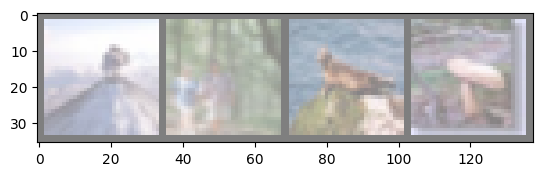

GroundTruth:  mountain forest seal  mushroom


In [ ]:
testloader = torch.utils.data.DataLoader(cifar100_test, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{cifar100classes[labels[j]]:5s}' for j in range(batch_size)))

#### Define the eval function

In [9]:
def test_model(testset, net=None, net_path=None, num_classes=None):
    if net is None:
        assert num_classes is not None, "Number of classes should be provided when loading saved network."
        net = LargeNet(num_classes)
        net.load_state_dict(torch.load(net_path))
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)
    correct = 0
    total = 0
    outputs = []
    test_examples_per_class = np.zeros(num_classes)
    correct_preds_per_class = np.zeros(num_classes)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            output = net(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            outputs.append(output)
            outputs.append(output)
            for i in range(len(predicted)):
              test_examples_per_class[int(labels[i].tolist())] += 1
              if int(labels[i].tolist()) == int(predicted[i].tolist()):
                correct_preds_per_class[int(labels[i].tolist())] += 1
    accuracy = correct / total
    class_accs = [float(m/n) for m, n in zip(correct_preds_per_class, test_examples_per_class)]
    print(f"Accuracy: {round(100 * accuracy, 2)} %")
    print("Accuracy per class: " + str(class_accs))
    print("Min single-class accuracy: " + str(100*min(class_accs)) + " %")
    print("Max single-class accuracy: " + str(100*max(class_accs)) + " %")
    print("Num classes above 0 test accuracy: " + str(sum(correct_preds_per_class>0)) + "\n")
    return outputs, accuracy

### 4-1) Use the models trained on the fly

In [ ]:
cifar10_outputs = {}
cifar100_outputs = {}
svhn_outputs = {}
dtd_outputs = {}
food101_outputs = {}
gtsrb_outputs = {}

for frac in subset_sizes:
    print(f"Testing CIFAR10 for SAS subset size: {frac}")
    cifar10_outputs[frac] = test_model(cifar10_test, net=cifar10_nn[frac], num_classes=10)

for frac in subset_sizes:
    print(f"Testing CIFAR100 for SAS subset size: {frac}")
    cifar100_outputs[frac] = test_model(cifar100_test, net=cifar100_nn[frac], num_classes=100)

for frac in subset_sizes:
    print(f"Testing SVHN for SAS subset size: {frac}")
    svhn_outputs[frac] = test_model(svhn_test, net=svhn_nn[frac], num_classes=10)

for frac in subset_sizes:
    print(f"Testing DTD for SAS subset size: {frac}")
    dtd_outputs[frac] = test_model(dtd_test, net=dtd_nn[frac], num_classes=47)

for frac in subset_sizes:
    print(f"Testing FOOD101 for SAS subset size: {frac}")
    food101_outputs[frac] = test_model(food101_test, net=food101_nn[frac], num_classes=101)

for frac in subset_sizes:
    print(f"Testing GTSRB for SAS subset size: {frac}")
    gtsrb_outputs[frac] = test_model(gtsrb_test, net=gtsrb_nn[frac], num_classes=43)

Testing CIFAR10 for subset size: 0.05
Accuracy: 10.0 %
Accuracy per class: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Min single-class accuracy: 0.0 %
Max single-class accuracy: 100.0 %
Num classes above 0 test accuracy: 1

Testing CIFAR10 for subset size: 0.1
Accuracy: 28.62 %
Accuracy per class: [0.468 0.419 0.012 0.232 0.001 0.363 0.528 0.333 0.269 0.237]
Min single-class accuracy: 0.1 %
Max single-class accuracy: 52.800000000000004 %
Num classes above 0 test accuracy: 10

Testing CIFAR10 for subset size: 0.15
Accuracy: 36.06 %
Accuracy per class: [0.441 0.461 0.119 0.319 0.51  0.149 0.302 0.366 0.441 0.498]
Min single-class accuracy: 11.899999999999999 %
Max single-class accuracy: 51.0 %
Num classes above 0 test accuracy: 10

Testing CIFAR10 for subset size: 0.2
Accuracy: 32.24 %
Accuracy per class: [0.181 0.579 0.013 0.081 0.275 0.142 0.646 0.442 0.35  0.515]
Min single-class accuracy: 1.3 %
Max single-class accuracy: 64.60000000000001 %
Num classes above 0 test accuracy: 10

Testing CIFAR10

### 4-2) Load back the saved models

In [17]:
cifar10_outputs = {}
cifar100_outputs = {}
svhn_outputs = {}
dtd_outputs = {}
food101_outputs = {}

for frac in subset_sizes:
  print(f"Testing CIFAR10 for SAS subset size: {frac}")
  cifar10path = model_path + f"/SAS/CIFAR10/cifar10-{frac}.pth"
  cifar10_outputs[frac] = test_model(cifar10_test, net_path=cifar10path, num_classes=10)

for frac in subset_sizes:
  print(f"Testing CIFAR100 for SAS subset size: {frac}")
  cifar100path = model_path + f"/SAS/CIFAR100/cifar100-{frac}.pth"
  cifar100_outputs[frac] = test_model(cifar100_test, net_path=cifar100path, num_classes=100)

for frac in subset_sizes:
  print(f"Testing SVHN for SAS subset size: {frac}")
  svhnpath = model_path + f"/SAS/SVHN/svhn-{frac}.pth"
  svhn_outputs[frac] = test_model(svhn_test, net_path=svhnpath, num_classes=10)

for frac in subset_sizes:
  print(f"Testing DTD for SAS subset size: {frac}")
  dtdpath = model_path + f"/SAS/DTD/dtd-{frac}.pth"
  dtd_outputs[frac] = test_model(dtd_test, net_path=dtdpath, num_classes=47)

for frac in subset_sizes:
  print(f"Testing FOOD101 for SAS subset size: {frac}")
  food101path = model_path + f"/SAS/FOOD101/food101-{frac}.pth"
  food101_outputs[frac] = test_model(food101_test, net_path=food101path, num_classes=101)

Testing CIFAR10 for SAS subset size: 0.05
Accuracy: 38.75 %
Accuracy per class: [0.169, 0.353, 0.265, 0.245, 0.313, 0.316, 0.643, 0.48, 0.402, 0.689]
Min single-class accuracy: 16.900000000000002 %
Max single-class accuracy: 68.89999999999999 %
Num classes above 0 test accuracy: 10

Testing CIFAR10 for SAS subset size: 0.1
Accuracy: 46.24 %
Accuracy per class: [0.568, 0.723, 0.488, 0.329, 0.166, 0.377, 0.503, 0.407, 0.509, 0.554]
Min single-class accuracy: 16.6 %
Max single-class accuracy: 72.3 %
Num classes above 0 test accuracy: 10

Testing CIFAR10 for SAS subset size: 0.15
Accuracy: 49.34 %
Accuracy per class: [0.453, 0.731, 0.366, 0.417, 0.434, 0.543, 0.497, 0.442, 0.49, 0.561]
Min single-class accuracy: 36.6 %
Max single-class accuracy: 73.1 %
Num classes above 0 test accuracy: 10

Testing CIFAR10 for SAS subset size: 0.2
Accuracy: 48.33 %
Accuracy per class: [0.305, 0.562, 0.393, 0.302, 0.415, 0.426, 0.725, 0.505, 0.472, 0.728]
Min single-class accuracy: 30.2 %
Max single-class a

FileNotFoundError: ignored

In [30]:
gtsrb_outputs = {}

for frac in subset_sizes:
  print(f"Testing GTSRB for SAS subset size: {frac}")
  gtsrbpath = model_path + f"/SAS/GTSRB/gtsrb-{frac}.pth"
  gtsrb_outputs[frac] = test_model(gtsrb_test, net_path=gtsrbpath, num_classes=43)

Testing GTSRB for SAS subset size: 0.05
Accuracy: 35.24 %
Accuracy per class: [0.0, 0.4361111111111111, 0.02, 0.28888888888888886, 0.4636363636363636, 0.7603174603174603, 0.22, 0.02, 0.017777777777777778, 0.5729166666666666, 0.6924242424242424, 0.2785714285714286, 0.7956521739130434, 0.7694444444444445, 0.7555555555555555, 0.0380952380952381, 0.5, 0.7861111111111111, 0.06153846153846154, 0.0, 0.0, 0.0, 0.8833333333333333, 0.19333333333333333, 0.0, 0.10833333333333334, 0.0, 0.16666666666666666, 0.02666666666666667, 0.0, 0.0, 0.43703703703703706, 0.0, 0.6047619047619047, 0.0, 0.17435897435897435, 0.0, 0.0, 0.14057971014492754, 0.0, 0.0, 0.0, 0.0]
Min single-class accuracy: 0.0 %
Max single-class accuracy: 88.33333333333333 %
Num classes above 0 test accuracy: 27

Testing GTSRB for SAS subset size: 0.1
Accuracy: 43.66 %
Accuracy per class: [0.0, 0.3861111111111111, 0.6026666666666667, 0.41333333333333333, 0.5181818181818182, 0.09365079365079365, 0.0, 0.051111111111111114, 0.13555555555555

## 5) Train and test with random selections

### 5-a) Define a random subset function

In [40]:
def get_random_subset(train_data, subset_frac):
  subset_dataset = RandomSubsetDataset(
      dataset=train_data,
      subset_fraction=subset_frac,
      verbose=True
  )
  return subset_dataset

### 5-b) Generate CIFAR10 and CIFAR100 random subsets of Varying Size (5%, 10%, 15%, 20%, 30%, 40%, 60%, 80%)

#### 5-b-1) Run random selection for CIFAR10 and CIFAR100

In [58]:
cifar10_train_random_sub = {}
cifar100_train_random_sub = {}
svhn_train_random_sub = {}
dtd_train_random_sub = {}
food101_train_random_sub = {}
gtsrb_train_random_sub = {}

for frac in subset_sizes:

    cifar10_random_out = get_random_subset(cifar10_train, frac)
    cifar100_random_out = get_random_subset(cifar100_train, frac)
    svhn_random_out = get_random_subset(svhn_train, frac)
    dtd_random_out = get_random_subset(dtd_train, frac)
    food101_random_out = get_random_subset(food101_train, frac)
    gtsrb_random_out = get_random_subset(gtsrb_train, frac)

    cifar10_train_random_sub[frac] = cifar10_random_out
    cifar100_train_random_sub[frac] = cifar100_random_out
    svhn_train_random_sub[frac] = svhn_random_out
    dtd_train_random_sub[frac] = dtd_random_out
    food101_train_random_sub[frac] = food101_random_out
    gtsrb_train_random_sub[frac] = gtsrb_random_out

    cifar10_random_out.save_to_file(f"{subset_path}/Random/CIFAR10/cifar10-{frac}-random-indices.pkl")
    cifar100_random_out.save_to_file(f"{subset_path}/Random/CIFAR100/cifar100-{frac}-random-indices.pkl")
    svhn_random_out.save_to_file(f"{subset_path}/Random/SVHN/svhn-{frac}-random-indices.pkl")
    dtd_random_out.save_to_file(f"{subset_path}/Random/DTD/dtd-{frac}-random-indices.pkl")
    food101_random_out.save_to_file(f"{subset_path}/Random/FOOD101/food101-{frac}-random-indices.pkl")
    gtsrb_random_out.save_to_file(f"{subset_path}/Random/GTSRB/gtsrb-{frac}-random-indices.pkl")

    files.download(f"{subset_path}/Random/CIFAR10/cifar10-{frac}-random-indices.pkl")
    files.download(f"{subset_path}/Random/CIFAR100/cifar100-{frac}-random-indices.pkl")
    files.download(f"{subset_path}/Random/SVHN/svhn-{frac}-random-indices.pkl")
    files.download(f"{subset_path}/Random/DTD/dtd-{frac}-random-indices.pkl")
    files.download(f"{subset_path}/Random/FOOD101/food101-{frac}-random-indices.pkl")
    files.download(f"{subset_path}/Random/GTSRB/gtsrb-{frac}-random-indices.pkl")

Subset Size: 2500
Discarded 47500 examples
Subset Size: 2500
Discarded 47500 examples
Subset Size: 3662
Discarded 69595 examples
Subset Size: 94
Discarded 1786 examples
Subset Size: 1262
Discarded 23988 examples
Subset Size: 1332
Discarded 25308 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Subset Size: 5000
Discarded 45000 examples
Subset Size: 5000
Discarded 45000 examples
Subset Size: 7325
Discarded 65932 examples
Subset Size: 188
Discarded 1692 examples
Subset Size: 2525
Discarded 22725 examples
Subset Size: 2664
Discarded 23976 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Subset Size: 7500
Discarded 42500 examples
Subset Size: 7500
Discarded 42500 examples
Subset Size: 10988
Discarded 62269 examples
Subset Size: 282
Discarded 1598 examples
Subset Size: 3787
Discarded 21463 examples
Subset Size: 3996
Discarded 22644 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Subset Size: 10000
Discarded 40000 examples
Subset Size: 10000
Discarded 40000 examples
Subset Size: 14651
Discarded 58606 examples
Subset Size: 376
Discarded 1504 examples
Subset Size: 5050
Discarded 20200 examples
Subset Size: 5328
Discarded 21312 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Subset Size: 15000
Discarded 35000 examples
Subset Size: 15000
Discarded 35000 examples
Subset Size: 21977
Discarded 51280 examples
Subset Size: 564
Discarded 1316 examples
Subset Size: 7575
Discarded 17675 examples
Subset Size: 7992
Discarded 18648 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Subset Size: 20000
Discarded 30000 examples
Subset Size: 20000
Discarded 30000 examples
Subset Size: 29302
Discarded 43955 examples
Subset Size: 752
Discarded 1128 examples
Subset Size: 10100
Discarded 15150 examples
Subset Size: 10656
Discarded 15984 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Subset Size: 30000
Discarded 20000 examples
Subset Size: 30000
Discarded 20000 examples
Subset Size: 43954
Discarded 29303 examples
Subset Size: 1128
Discarded 752 examples
Subset Size: 15150
Discarded 10100 examples
Subset Size: 15984
Discarded 10656 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Subset Size: 40000
Discarded 10000 examples
Subset Size: 40000
Discarded 10000 examples
Subset Size: 58605
Discarded 14652 examples
Subset Size: 1504
Discarded 376 examples
Subset Size: 20200
Discarded 5050 examples
Subset Size: 21312
Discarded 5328 examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 5-b-2) Load pre-saved subset selections

In [10]:
cifar100_train_random_sub = {}
cifar10_train_random_sub = {}
svhn_train_random_sub = {}
dtd_train_random_sub = {}
food101_train_random_sub = {}
gtsrb_train_random_sub = {}

for frac in subset_sizes:
    with open(f"{subset_path}/Random/CIFAR100/cifar100-{frac}-random-indices.pkl", "rb") as f:
        cifar100_idx = pickle.load(f)
        cifar100_train_random_sub[frac] = CustomSubsetDataset(cifar100_train, subset_indices=cifar100_idx)
    with open(f"{subset_path}/Random/CIFAR10/cifar10-{frac}-random-indices.pkl", "rb") as f:
        cifar10_idx = pickle.load(f)
        cifar10_train_random_sub[frac] = CustomSubsetDataset(cifar10_train, subset_indices=cifar10_idx)
    with open(f"{subset_path}/Random/SVHN/svhn-{frac}-random-indices.pkl", "rb") as f:
        svhn_idx = pickle.load(f)
        svhn_train_random_sub[frac] = CustomSubsetDataset(svhn_train, subset_indices=svhn_idx)
    with open(f"{subset_path}/Random/DTD/dtd-{frac}-random-indices.pkl", "rb") as f:
        dtd_idx = pickle.load(f)
        dtd_train_random_sub[frac] = CustomSubsetDataset(dtd_train, subset_indices=dtd_idx)
    with open(f"{subset_path}/Random/FOOD101/food101-{frac}-random-indices.pkl", "rb") as f:
        food101_idx = pickle.load(f)
        food101_train_random_sub[frac] = CustomSubsetDataset(food101_train, subset_indices=food101_idx)
    with open(f"{subset_path}/Random/GTSRB/gtsrb-{frac}-random-indices.pkl", "rb") as f:
        gtsrb_idx = pickle.load(f)
        gtsrb_train_random_sub[frac] = CustomSubsetDataset(gtsrb_train, subset_indices=gtsrb_idx)

### 5-c) Train the selected random subsets on Neural Network and save models

In [63]:
print("Start FOOD101 training:")
food101_nn_random = {}
for frac in subset_sizes:
    print(f"Training FOOD101 for random subset size: {frac}")
    trainset = food101_train_random_sub[frac]
    path = model_path + f"/Random/FOOD101/food101-{frac}-random"
    food101_nn_random[frac] = train_model(trainset, 101, food101_epochs, batch_size, num_workers, path)
    files.download(f"{model_path}/Random/FOOD101/food101-{frac}-random.pth")

print("Start CIFAR100 training:")
cifar100_nn_random = {}
for frac in subset_sizes:
    print(f"Training CIFAR100 for random subset size: {frac}")
    trainset = cifar100_train_random_sub[frac]
    path = model_path + f"/Random/CIFAR100/cifar100-{frac}-random"
    cifar100_nn_random[frac] = train_model(trainset, 100, cifar100_epochs, batch_size, num_workers, path)
    files.download(f"{model_path}/Random/CIFAR100/cifar100-{frac}-random.pth")

print("Start CIFAR10 training:")
cifar10_nn_random = {}
for frac in subset_sizes:
    print(f"Training CIFAR10 for random subset size: {frac}")
    trainset = cifar10_train_random_sub[frac]
    path = model_path + f"/Random/CIFAR10/cifar10-{frac}-random"
    cifar10_nn_random[frac] = train_model(trainset, 10, cifar10_epochs, batch_size, num_workers, path)
    files.download(f"{model_path}/Random/CIFAR10/cifar10-{frac}-random.pth")

print("Start SVHN training:")
svhn_nn_random = {}
for frac in subset_sizes:
    print(f"Training SVHN for random subset size: {frac}")
    trainset = svhn_train_random_sub[frac]
    path = model_path + f"/Random/SVHN/svhn-{frac}-random"
    svhn_nn_random[frac] = train_model(trainset, 10, svhn_epochs, batch_size, num_workers, path)
    files.download(f"{model_path}/Random/SVHN/svhn-{frac}-random.pth")

print("Start DTD training:")
dtd_nn_random = {}
for frac in subset_sizes:
    print(f"Training DTD for random subset size: {frac}")
    trainset = dtd_train_random_sub[frac]
    path = model_path + f"/Random/DTD/dtd-{frac}-random"
    dtd_nn_random[frac] = train_model(trainset, 47, dtd_epochs, batch_size, num_workers, path)
    files.download(f"{model_path}/Random/DTD/dtd-{frac}-random.pth")

print("Start GTSRB training:")
gtsrb_nn_random = {}
for frac in subset_sizes:
    print(f"Training GTSRB for random subset size: {frac}")
    trainset = gtsrb_train_random_sub[frac]
    path = model_path + f"/Random/GTSRB/gtsrb-{frac}-random"
    gtsrb_nn_random[frac] = train_model(trainset, 43, gtsrb_epochs, batch_size, num_workers, path)
    files.download(f"{model_path}/Random/GTSRB/gtsrb-{frac}-random.pth")

Start FOOD101 training:
Training FOOD101 for random subset size: 0.05
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training FOOD101 for random subset size: 0.1
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training FOOD101 for random subset size: 0.15
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training FOOD101 for random subset size: 0.2
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training FOOD101 for random subset size: 0.3
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training FOOD101 for random subset size: 0.4
[1,  2000] loss: 4.618
[2,  2000] loss: 4.616
[3,  2000] loss: 4.615
[4,  2000] loss: 4.614
[5,  2000] loss: 4.615
[6,  2000] loss: 4.615
[7,  2000] loss: 4.615
[8,  2000] loss: 4.614
[9,  2000] loss: 4.614
[10,  2000] loss: 4.615
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training FOOD101 for random subset size: 0.6
[1,  2000] loss: 4.618
[2,  2000] loss: 4.616
[3,  2000] loss: 4.609
[4,  2000] loss: 4.513
[5,  2000] loss: 4.444
[6,  2000] loss: 4.332
[7,  2000] loss: 4.214
[8,  2000] loss: 4.148
[9,  2000] loss: 4.088
[10,  2000] loss: 4.017
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training FOOD101 for random subset size: 0.8
[1,  2000] loss: 4.619
[1,  4000] loss: 4.588
[2,  2000] loss: 4.425
[2,  4000] loss: 4.336
[3,  2000] loss: 4.182
[3,  4000] loss: 4.169
[4,  2000] loss: 4.068
[4,  4000] loss: 4.035
[5,  2000] loss: 3.929
[5,  4000] loss: 3.961
[6,  2000] loss: 3.854
[6,  4000] loss: 3.879
[7,  2000] loss: 3.782
[7,  4000] loss: 3.804
[8,  2000] loss: 3.737
[8,  4000] loss: 3.738
[9,  2000] loss: 3.651
[9,  4000] loss: 3.692
[10,  2000] loss: 3.578
[10,  4000] loss: 3.650
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start CIFAR100 training:
Training CIFAR100 for random subset size: 0.05
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training CIFAR100 for random subset size: 0.1
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training CIFAR100 for random subset size: 0.15
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training CIFAR100 for random subset size: 0.2
[1,  2000] loss: 4.543
[2,  2000] loss: 4.279
[3,  2000] loss: 4.100
[4,  2000] loss: 3.988
[5,  2000] loss: 3.885
[6,  2000] loss: 3.773
[7,  2000] loss: 3.680
[8,  2000] loss: 3.605
[9,  2000] loss: 3.520
[10,  2000] loss: 3.430
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training CIFAR100 for random subset size: 0.3
[1,  2000] loss: 4.518
[2,  2000] loss: 4.134
[3,  2000] loss: 3.885
[4,  2000] loss: 3.718
[5,  2000] loss: 3.577
[6,  2000] loss: 3.458
[7,  2000] loss: 3.401
[8,  2000] loss: 3.317
[9,  2000] loss: 3.233
[10,  2000] loss: 3.134
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training CIFAR100 for random subset size: 0.4
[1,  2000] loss: 4.508
[1,  4000] loss: 4.309
[2,  2000] loss: 4.071
[2,  4000] loss: 3.960
[3,  2000] loss: 3.777
[3,  4000] loss: 3.710
[4,  2000] loss: 3.588
[4,  4000] loss: 3.539
[5,  2000] loss: 3.425
[5,  4000] loss: 3.419
[6,  2000] loss: 3.299
[6,  4000] loss: 3.302
[7,  2000] loss: 3.176
[7,  4000] loss: 3.202
[8,  2000] loss: 3.122
[8,  4000] loss: 3.121
[9,  2000] loss: 3.011
[9,  4000] loss: 3.062
[10,  2000] loss: 2.952
[10,  4000] loss: 2.997
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training CIFAR100 for random subset size: 0.6
[1,  2000] loss: 4.456
[1,  4000] loss: 4.278
[1,  6000] loss: 4.194
[2,  2000] loss: 3.996
[2,  4000] loss: 3.939
[2,  6000] loss: 3.895
[3,  2000] loss: 3.728
[3,  4000] loss: 3.704
[3,  6000] loss: 3.649
[4,  2000] loss: 3.501
[4,  4000] loss: 3.476
[4,  6000] loss: 3.463
[5,  2000] loss: 3.314
[5,  4000] loss: 3.350
[5,  6000] loss: 3.303
[6,  2000] loss: 3.214
[6,  4000] loss: 3.235
[6,  6000] loss: 3.229
[7,  2000] loss: 3.121
[7,  4000] loss: 3.099
[7,  6000] loss: 3.155
[8,  2000] loss: 2.997
[8,  4000] loss: 3.054
[8,  6000] loss: 3.053
[9,  2000] loss: 2.931
[9,  4000] loss: 2.946
[9,  6000] loss: 3.003
[10,  2000] loss: 2.885
[10,  4000] loss: 2.916
[10,  6000] loss: 2.900
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training CIFAR100 for random subset size: 0.8
[1,  2000] loss: 4.607
[1,  4000] loss: 4.427
[1,  6000] loss: 4.198
[1,  8000] loss: 4.052
[1, 10000] loss: 3.973
[2,  2000] loss: 3.877
[2,  4000] loss: 3.832
[2,  6000] loss: 3.788
[2,  8000] loss: 3.767
[2, 10000] loss: 3.717
[3,  2000] loss: 3.640
[3,  4000] loss: 3.580
[3,  6000] loss: 3.600
[3,  8000] loss: 3.559
[3, 10000] loss: 3.492
[4,  2000] loss: 3.429
[4,  4000] loss: 3.423
[4,  6000] loss: 3.426
[4,  8000] loss: 3.406
[4, 10000] loss: 3.394
[5,  2000] loss: 3.327
[5,  4000] loss: 3.259
[5,  6000] loss: 3.314
[5,  8000] loss: 3.293
[5, 10000] loss: 3.269
[6,  2000] loss: 3.228
[6,  4000] loss: 3.217
[6,  6000] loss: 3.216
[6,  8000] loss: 3.218
[6, 10000] loss: 3.178
[7,  2000] loss: 3.149
[7,  4000] loss: 3.149
[7,  6000] loss: 3.179
[7,  8000] loss: 3.122
[7, 10000] loss: 3.103
[8,  2000] loss: 3.030
[8,  4000] loss: 3.068
[8,  6000] loss: 3.108
[8,  8000] loss: 3.079
[8, 10000] loss: 3.128
[9,  2000] loss: 2.986
[9,  4000] 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start CIFAR10 training:
Training CIFAR10 for random subset size: 0.05
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training CIFAR10 for random subset size: 0.1
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training CIFAR10 for random subset size: 0.15
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training CIFAR10 for random subset size: 0.2
[1,  2000] loss: 2.032
[2,  2000] loss: 1.638
[3,  2000] loss: 1.453
[4,  2000] loss: 1.322
[5,  2000] loss: 1.212
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training CIFAR10 for random subset size: 0.3
[1,  2000] loss: 1.976
[2,  2000] loss: 1.546
[3,  2000] loss: 1.355
[4,  2000] loss: 1.235
[5,  2000] loss: 1.142
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training CIFAR10 for random subset size: 0.4
[1,  2000] loss: 2.037
[1,  4000] loss: 1.715
[2,  2000] loss: 1.499
[2,  4000] loss: 1.400
[3,  2000] loss: 1.294
[3,  4000] loss: 1.263
[4,  2000] loss: 1.170
[4,  4000] loss: 1.165
[5,  2000] loss: 1.086
[5,  4000] loss: 1.080
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training CIFAR10 for random subset size: 0.6
[1,  2000] loss: 1.988
[1,  4000] loss: 1.699
[1,  6000] loss: 1.545
[2,  2000] loss: 1.366
[2,  4000] loss: 1.325
[2,  6000] loss: 1.289
[3,  2000] loss: 1.184
[3,  4000] loss: 1.158
[3,  6000] loss: 1.153
[4,  2000] loss: 1.060
[4,  4000] loss: 1.055
[4,  6000] loss: 1.058
[5,  2000] loss: 0.976
[5,  4000] loss: 0.982
[5,  6000] loss: 0.995
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training CIFAR10 for random subset size: 0.8
[1,  2000] loss: 2.065
[1,  4000] loss: 1.718
[1,  6000] loss: 1.586
[1,  8000] loss: 1.519
[1, 10000] loss: 1.429
[2,  2000] loss: 1.374
[2,  4000] loss: 1.343
[2,  6000] loss: 1.313
[2,  8000] loss: 1.298
[2, 10000] loss: 1.267
[3,  2000] loss: 1.173
[3,  4000] loss: 1.168
[3,  6000] loss: 1.157
[3,  8000] loss: 1.160
[3, 10000] loss: 1.151
[4,  2000] loss: 1.068
[4,  4000] loss: 1.070
[4,  6000] loss: 1.076
[4,  8000] loss: 1.070
[4, 10000] loss: 1.069
[5,  2000] loss: 0.992
[5,  4000] loss: 0.992
[5,  6000] loss: 1.004
[5,  8000] loss: 1.025
[5, 10000] loss: 1.008
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start SVHN training:
Training SVHN for random subset size: 0.05
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training SVHN for random subset size: 0.1
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training SVHN for random subset size: 0.15
[1,  2000] loss: 2.195
[2,  2000] loss: 1.149
[3,  2000] loss: 0.764
[4,  2000] loss: 0.613
[5,  2000] loss: 0.511
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training SVHN for random subset size: 0.2
[1,  2000] loss: 2.176
[2,  2000] loss: 1.055
[3,  2000] loss: 0.687
[4,  2000] loss: 0.551
[5,  2000] loss: 0.468
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training SVHN for random subset size: 0.3
[1,  2000] loss: 2.219
[1,  4000] loss: 1.792
[2,  2000] loss: 1.002
[2,  4000] loss: 0.874
[3,  2000] loss: 0.701
[3,  4000] loss: 0.670
[4,  2000] loss: 0.590
[4,  4000] loss: 0.565
[5,  2000] loss: 0.504
[5,  4000] loss: 0.528
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training SVHN for random subset size: 0.4
[1,  2000] loss: 2.247
[1,  4000] loss: 2.241
[1,  6000] loss: 2.236
[2,  2000] loss: 2.245
[2,  4000] loss: 2.234
[2,  6000] loss: 2.237
[3,  2000] loss: 2.237
[3,  4000] loss: 2.237
[3,  6000] loss: 2.241
[4,  2000] loss: 2.240
[4,  4000] loss: 2.239
[4,  6000] loss: 2.240
[5,  2000] loss: 2.236
[5,  4000] loss: 2.240
[5,  6000] loss: 2.243
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training SVHN for random subset size: 0.6
[1,  2000] loss: 2.204
[1,  4000] loss: 1.861
[1,  6000] loss: 1.333
[1,  8000] loss: 1.014
[1, 10000] loss: 0.850
[2,  2000] loss: 0.679
[2,  4000] loss: 0.675
[2,  6000] loss: 0.638
[2,  8000] loss: 0.607
[2, 10000] loss: 0.607
[3,  2000] loss: 0.530
[3,  4000] loss: 0.527
[3,  6000] loss: 0.547
[3,  8000] loss: 0.548
[3, 10000] loss: 0.534
[4,  2000] loss: 0.489
[4,  4000] loss: 0.485
[4,  6000] loss: 0.497
[4,  8000] loss: 0.481
[4, 10000] loss: 0.475
[5,  2000] loss: 0.435
[5,  4000] loss: 0.439
[5,  6000] loss: 0.446
[5,  8000] loss: 0.445
[5, 10000] loss: 0.442
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training SVHN for random subset size: 0.8
[1,  2000] loss: 2.245
[1,  4000] loss: 1.867
[1,  6000] loss: 1.147
[1,  8000] loss: 0.899
[1, 10000] loss: 0.765
[1, 12000] loss: 0.685
[1, 14000] loss: 0.645
[2,  2000] loss: 0.565
[2,  4000] loss: 0.574
[2,  6000] loss: 0.536
[2,  8000] loss: 0.548
[2, 10000] loss: 0.517
[2, 12000] loss: 0.504
[2, 14000] loss: 0.490
[3,  2000] loss: 0.457
[3,  4000] loss: 0.456
[3,  6000] loss: 0.484
[3,  8000] loss: 0.474
[3, 10000] loss: 0.435
[3, 12000] loss: 0.462
[3, 14000] loss: 0.449
[4,  2000] loss: 0.400
[4,  4000] loss: 0.422
[4,  6000] loss: 0.431
[4,  8000] loss: 0.422
[4, 10000] loss: 0.410
[4, 12000] loss: 0.404
[4, 14000] loss: 0.428
[5,  2000] loss: 0.383
[5,  4000] loss: 0.408
[5,  6000] loss: 0.399
[5,  8000] loss: 0.385
[5, 10000] loss: 0.395
[5, 12000] loss: 0.389
[5, 14000] loss: 0.390
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start DTD training:
Training DTD for random subset size: 0.05
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training DTD for random subset size: 0.1
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training DTD for random subset size: 0.15
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training DTD for random subset size: 0.2
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training DTD for random subset size: 0.3
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training DTD for random subset size: 0.4
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training DTD for random subset size: 0.6
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training DTD for random subset size: 0.8
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start GTSRB training:
Training GTSRB for random subset size: 0.05
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training GTSRB for random subset size: 0.1
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training GTSRB for random subset size: 0.15
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training GTSRB for random subset size: 0.2
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training GTSRB for random subset size: 0.3
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training GTSRB for random subset size: 0.4
[1,  2000] loss: 2.884
[2,  2000] loss: 1.233
[3,  2000] loss: 0.432
[4,  2000] loss: 0.217
[5,  2000] loss: 0.149
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training GTSRB for random subset size: 0.6
[1,  2000] loss: 2.683
[2,  2000] loss: 0.612
[3,  2000] loss: 0.238
[4,  2000] loss: 0.145
[5,  2000] loss: 0.107
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training GTSRB for random subset size: 0.8
[1,  2000] loss: 2.929
[1,  4000] loss: 1.322
[2,  2000] loss: 0.466
[2,  4000] loss: 0.344
[3,  2000] loss: 0.200
[3,  4000] loss: 0.185
[4,  2000] loss: 0.141
[4,  4000] loss: 0.124
[5,  2000] loss: 0.101
[5,  4000] loss: 0.114
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 5-d) Test the network trained on random selection on the test data

#### 5-d-1) Use the models trained on the fly

In [ ]:
cifar10_outputs_random = {}
cifar100_outputs_random = {}
svhn_outputs_random = {}
dtd_outputs_random = {}
food101_outputs_random = {}
gtsrb_outputs_random = {}

for frac in subset_sizes:
    print(f"Testing CIFAR100 for random subset size: {frac}")
    cifar10_outputs_random[frac] = test_model(cifar10_test, net=cifar10_nn_random[frac], num_classes=10)

for frac in subset_sizes:
    print(f"Testing CIFAR10 for random subset size: {frac}")
    cifar100_outputs_random[frac] = test_model(cifar100_test, net=cifar100_nn_random[frac], num_classes=100)

for frac in subset_sizes:
    print(f"Testing SVHN for random subset size: {frac}")
    svhn_outputs_random[frac] = test_model(svhn_test, net=svhn_nn_random[frac], num_classes=10)

for frac in subset_sizes:
    print(f"Testing DTD for random subset size: {frac}")
    dtd_outputs_random[frac] = test_model(dtd_test, net=dtd_nn_random[frac], num_classes=47)

for frac in subset_sizes:
    print(f"Testing Food101 for random subset size: {frac}")
    food101_outputs_random[frac] = test_model(food101_test, net=food101_nn_random[frac], num_classes=101)

for frac in subset_sizes:
    print(f"Testing GTSRB for random subset size: {frac}")
    gtsrb_outputs_random[frac] = test_model(gtsrb_test, net=gtsrb_nn_random[frac], num_classes=43)

#### 5-d-2) Load back the saved models

In [13]:
cifar10_outputs_random = {}
cifar100_outputs_random = {}
svhn_outputs_random = {}
dtd_outputs_random = {}
food101_outputs_random = {}
# gtsrb_outputs_random = {}

for frac in subset_sizes:
  print(f"Testing CIFAR10 for random subset size: {frac}")
  cifar10path = model_path + f"/Random/CIFAR10/cifar10-{frac}-random.pth"
  cifar10_outputs_random[frac] = test_model(cifar10_test, net_path=cifar10path, num_classes=10)

for frac in subset_sizes:
  print(f"Testing CIFAR100 for random subset size: {frac}")
  cifar100path = model_path + f"/Random/CIFAR100/cifar100-{frac}-random.pth"
  cifar100_outputs_random[frac] = test_model(cifar100_test, net_path=cifar100path, num_classes=100)

for frac in subset_sizes:
  print(f"Testing SVHN for random subset size: {frac}")
  svhnpath = model_path + f"/Random/SVHN/svhn-{frac}-random.pth"
  svhn_outputs_random[frac] = test_model(svhn_test, net_path=svhnpath, num_classes=10)

for frac in subset_sizes:
  print(f"Testing DTD for random subset size: {frac}")
  dtdpath = model_path + f"/Random/DTD/dtd-{frac}-random.pth"
  dtd_outputs_random[frac] = test_model(dtd_test, net_path=dtdpath, num_classes=47)

# for frac in subset_sizes:
#   print(f"Testing Food101 for random subset size: {frac}")
#   food101path = model_path + f"/Random/FOOD101/food101-{frac}-random.pth"
#   food101_outputs_random[frac] = test_model(food101_test, net_path=food101path, num_classes=101)

# for frac in subset_sizes:
#   print(f"Testing GTSRB for random subset size: {frac}")
#   gtsrbpath = model_path + f"/Random/GTSRB/gtsrb-{frac}-random.pth"
#   gtsrb_outputs_random[frac] = test_model(gtsrb_test, net_path=gtsrbpath, num_classes=43)

Testing CIFAR10 for random subset size: 0.05
Accuracy: 39.52 %
Accuracy per class: [0.36, 0.776, 0.156, 0.021, 0.161, 0.754, 0.494, 0.373, 0.499, 0.358]
Min single-class accuracy: 2.1 %
Max single-class accuracy: 77.60000000000001 %
Num classes above 0 test accuracy: 10

Testing CIFAR10 for random subset size: 0.1
Accuracy: 41.93 %
Accuracy per class: [0.495, 0.441, 0.193, 0.162, 0.324, 0.6, 0.621, 0.464, 0.444, 0.449]
Min single-class accuracy: 16.2 %
Max single-class accuracy: 62.1 %
Num classes above 0 test accuracy: 10

Testing CIFAR10 for random subset size: 0.15
Accuracy: 50.16 %
Accuracy per class: [0.6, 0.672, 0.395, 0.283, 0.366, 0.204, 0.709, 0.595, 0.678, 0.514]
Min single-class accuracy: 20.4 %
Max single-class accuracy: 70.89999999999999 %
Num classes above 0 test accuracy: 10

Testing CIFAR10 for random subset size: 0.2
Accuracy: 51.0 %
Accuracy per class: [0.604, 0.558, 0.387, 0.578, 0.262, 0.289, 0.526, 0.655, 0.718, 0.523]
Min single-class accuracy: 26.200000000000003 

In [17]:
for frac in subset_sizes:
  print(f"Testing Food101 for random subset size: {frac}")
  food101path = model_path + f"/Random/FOOD101/food101-{frac}-random.pth"
  food101_outputs_random[frac] = test_model(food101_test, net_path=food101path, num_classes=101)

Testing Food101 for random subset size: 0.05
Accuracy: 3.75 %
Accuracy per class: [0.0, 0.024, 0.0, 0.0, 0.024, 0.016, 0.032, 0.048, 0.0, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.212, 0.424, 0.0, 0.044, 0.0, 0.016, 0.028, 0.0, 0.0, 0.004, 0.04, 0.024, 0.0, 0.0, 0.044, 0.42, 0.7, 0.0, 0.0, 0.0, 0.008, 0.0, 0.012, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.044, 0.0, 0.0, 0.036, 0.004, 0.0, 0.028, 0.0, 0.008, 0.0, 0.048, 0.0, 0.068, 0.0, 0.0, 0.0, 0.012, 0.48, 0.0, 0.02, 0.0, 0.0, 0.04, 0.0, 0.004, 0.0, 0.0, 0.176, 0.0, 0.0, 0.0, 0.036, 0.0, 0.024, 0.048, 0.0, 0.0, 0.004, 0.108, 0.004, 0.228, 0.0, 0.0, 0.008, 0.0, 0.0, 0.016, 0.028, 0.0, 0.132, 0.0, 0.036, 0.0]
Min single-class accuracy: 0.0 %
Max single-class accuracy: 70.0 %
Num classes above 0 test accuracy: 45

Testing Food101 for random subset size: 0.1
Accuracy: 2.9 %
Accuracy per class: [0.0, 0.0, 0.0, 0.0, 0.036, 0.0, 0.0, 0.068, 0.0, 0.0, 0.072, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004, 0.036, 0.068, 0.0, 0.644, 0.0,

In [32]:
gtsrb_outputs_random = {}

for frac in subset_sizes:
  print(f"Testing GTSRB for random subset size: {frac}")
  gtsrbpath = model_path + f"/Random/GTSRB/gtsrb-{frac}-random.pth"
  gtsrb_outputs_random[frac] = test_model(gtsrb_test, net_path=gtsrbpath, num_classes=43)

Testing GTSRB for random subset size: 0.05
Accuracy: 42.37 %
Accuracy per class: [0.0, 0.6902777777777778, 0.4106666666666667, 0.2288888888888889, 0.15757575757575756, 0.04126984126984127, 0.22666666666666666, 0.0022222222222222222, 0.0, 0.8291666666666667, 0.9090909090909091, 0.8666666666666667, 0.9101449275362319, 0.9680555555555556, 0.7407407407407407, 0.0, 0.0, 0.8861111111111111, 0.005128205128205128, 0.0, 0.0, 0.0, 0.0, 0.26, 0.0, 0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05555555555555555, 0.0, 0.009523809523809525, 0.1, 0.5871794871794872, 0.0, 0.0, 0.9478260869565217, 0.0, 0.0, 0.0, 0.3888888888888889]
Min single-class accuracy: 0.0 %
Max single-class accuracy: 96.80555555555556 %
Num classes above 0 test accuracy: 23

Testing GTSRB for random subset size: 0.1
Accuracy: 51.19 %
Accuracy per class: [0.0, 0.5069444444444444, 0.29333333333333333, 0.12222222222222222, 0.0, 0.42698412698412697, 0.5466666666666666, 0.015555555555555555, 0.3, 0.94375, 0.9606060606060606, 0.680952380952381, 0

## 6) Training and testing on full data

In [20]:
print("Start CIFAR100 training:")
cifar100_nn_full = {}
print(f"Training CIFAR100 on full data")
trainset = cifar100_train
path = model_path + f"/Full/cifar100-full"
cifar100_nn_full = train_model(trainset, 100, cifar100_epochs, batch_size, num_workers, path)
files.download(f"{model_path}/Full/cifar100-full.pth")

print("Start CIFAR10 training:")
cifar10_nn_full = {}
print(f"Training CIFAR10 on full data")
trainset = cifar10_train
path = model_path + f"/Full/cifar10-full"
cifar10_nn_full = train_model(trainset, 10, cifar10_epochs, batch_size, num_workers, path)
files.download(f"{model_path}/Full/cifar10-full.pth")

print("Start SVHN training:")
svhn_nn_full = {}
print(f"Training SVHN on full data")
trainset = svhn_train
path = model_path + f"/Full/svhn-full"
svhn_nn_full = train_model(trainset, 10, svhn_epochs, batch_size, num_workers, path)
files.download(f"{model_path}/Full/svhn-full.pth")

print("Start DTD training:")
dtd_nn_full = {}
print(f"Training DTD on full data")
trainset = dtd_train
path = model_path + f"/Full/dtd-full"
dtd_nn_full = train_model(trainset, 47, dtd_epochs, batch_size, num_workers, path)
files.download(f"{model_path}/Full/dtd-full.pth")

# print("Start Food101 training:")
# food101_nn_full = {}
# print(f"Training on Food101 data")
# trainset = food101_train
# path = model_path + f"/food101-full"
# food101_nn_full = train_model(trainset, 101, food101_epochs, batch_size, num_workers, path)
# files.download(f"{model_path}/Full/food101-full.pth")

Start CIFAR100 training:
Training CIFAR100 on full data
[1,  2000] loss: 4.447
[1,  4000] loss: 4.246
[1,  6000] loss: 4.104
[1,  8000] loss: 3.997
[1, 10000] loss: 3.910
[1, 12000] loss: 3.837
[2,  2000] loss: 3.683
[2,  4000] loss: 3.645
[2,  6000] loss: 3.611
[2,  8000] loss: 3.560
[2, 10000] loss: 3.538
[2, 12000] loss: 3.478
[3,  2000] loss: 3.414
[3,  4000] loss: 3.368
[3,  6000] loss: 3.355
[3,  8000] loss: 3.347
[3, 10000] loss: 3.348
[3, 12000] loss: 3.330
[4,  2000] loss: 3.212
[4,  4000] loss: 3.225
[4,  6000] loss: 3.240
[4,  8000] loss: 3.206
[4, 10000] loss: 3.211
[4, 12000] loss: 3.223
[5,  2000] loss: 3.117
[5,  4000] loss: 3.136
[5,  6000] loss: 3.122
[5,  8000] loss: 3.121
[5, 10000] loss: 3.133
[5, 12000] loss: 3.099
[6,  2000] loss: 3.019
[6,  4000] loss: 3.068
[6,  6000] loss: 3.036
[6,  8000] loss: 3.068
[6, 10000] loss: 3.085
[6, 12000] loss: 3.058
[7,  2000] loss: 2.952
[7,  4000] loss: 3.000
[7,  6000] loss: 2.990
[7,  8000] loss: 2.996
[7, 10000] loss: 2.998
[

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start CIFAR10 training:
Training CIFAR10 on full data
[1,  2000] loss: 2.009
[1,  4000] loss: 1.701
[1,  6000] loss: 1.587
[1,  8000] loss: 1.507
[1, 10000] loss: 1.431
[1, 12000] loss: 1.376
[2,  2000] loss: 1.310
[2,  4000] loss: 1.306
[2,  6000] loss: 1.275
[2,  8000] loss: 1.256
[2, 10000] loss: 1.214
[2, 12000] loss: 1.248
[3,  2000] loss: 1.138
[3,  4000] loss: 1.146
[3,  6000] loss: 1.125
[3,  8000] loss: 1.095
[3, 10000] loss: 1.095
[3, 12000] loss: 1.113
[4,  2000] loss: 1.025
[4,  4000] loss: 1.025
[4,  6000] loss: 1.024
[4,  8000] loss: 1.032
[4, 10000] loss: 1.029
[4, 12000] loss: 1.020
[5,  2000] loss: 0.939
[5,  4000] loss: 0.931
[5,  6000] loss: 0.976
[5,  8000] loss: 0.962
[5, 10000] loss: 0.975
[5, 12000] loss: 0.968
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start SVHN training:
Training SVHN on full data
[1,  2000] loss: 2.235
[1,  4000] loss: 1.934
[1,  6000] loss: 1.315
[1,  8000] loss: 0.960
[1, 10000] loss: 0.834
[1, 12000] loss: 0.781
[1, 14000] loss: 0.725
[1, 16000] loss: 0.684
[1, 18000] loss: 0.690
[2,  2000] loss: 0.650
[2,  4000] loss: 0.624
[2,  6000] loss: 0.593
[2,  8000] loss: 0.619
[2, 10000] loss: 0.578
[2, 12000] loss: 0.579
[2, 14000] loss: 0.561
[2, 16000] loss: 0.562
[2, 18000] loss: 0.545
[3,  2000] loss: 0.514
[3,  4000] loss: 0.533
[3,  6000] loss: 0.537
[3,  8000] loss: 0.498
[3, 10000] loss: 0.524
[3, 12000] loss: 0.509
[3, 14000] loss: 0.490
[3, 16000] loss: 0.485
[3, 18000] loss: 0.500
[4,  2000] loss: 0.471
[4,  4000] loss: 0.475
[4,  6000] loss: 0.459
[4,  8000] loss: 0.480
[4, 10000] loss: 0.472
[4, 12000] loss: 0.449
[4, 14000] loss: 0.470
[4, 16000] loss: 0.479
[4, 18000] loss: 0.479
[5,  2000] loss: 0.422
[5,  4000] loss: 0.438
[5,  6000] loss: 0.431
[5,  8000] loss: 0.431
[5, 10000] loss: 0.446
[5, 12000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start DTD training:
Training DTD on full data
Finished Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Start Food101 training:
Training on Food101 data
[1,  2000] loss: 4.618
[1,  4000] loss: 4.604
[1,  6000] loss: 4.573
[1,  8000] loss: 4.538
[1, 10000] loss: 4.512
[1, 12000] loss: 4.481
[1, 14000] loss: 4.449
[1, 16000] loss: 4.407
[1, 18000] loss: 4.345
[2,  2000] loss: 4.303
[2,  4000] loss: 4.283
[2,  6000] loss: 4.240
[2,  8000] loss: 4.239
[2, 10000] loss: 4.211
[2, 12000] loss: 4.194
[2, 14000] loss: 4.173
[2, 16000] loss: 4.148
[2, 18000] loss: 4.139
[3,  2000] loss: 4.114
[3,  4000] loss: 4.091
[3,  6000] loss: 4.070
[3,  8000] loss: 4.070
[3, 10000] loss: 4.073
[3, 12000] loss: 4.061
[3, 14000] loss: 4.058
[3, 16000] loss: 4.038
[3, 18000] loss: 4.019
[4,  2000] loss: 4.001
[4,  4000] loss: 3.988
[4,  6000] loss: 4.020
[4,  8000] loss: 3.997
[4, 10000] loss: 3.988
[4, 12000] loss: 3.980
[4, 14000] loss: 4.001
[4, 16000] loss: 3.990
[4, 18000] loss: 3.980
[5,  2000] loss: 3.943
[5,  4000] loss: 3.941
[5,  6000] loss: 3.930
[5,  8000] loss: 3.955
[5, 10000] loss: 3.947
[5, 1200

FileNotFoundError: ignored

In [23]:
print("Start Food101 training:")
food101_nn_full = {}
print(f"Training on Food101 data")
trainset = food101_train
path = model_path + f"/Full/food101-full"
food101_nn_full = train_model(trainset, 101, food101_epochs, batch_size, num_workers, path)
files.download(f"{model_path}/Full/food101-full.pth")

Start Food101 training:
Training on Food101 data
[1,  2000] loss: 4.618
[1,  4000] loss: 4.586
[1,  6000] loss: 4.521
[1,  8000] loss: 4.481
[1, 10000] loss: 4.419
[1, 12000] loss: 4.374
[1, 14000] loss: 4.352
[1, 16000] loss: 4.332
[1, 18000] loss: 4.287
[2,  2000] loss: 4.235
[2,  4000] loss: 4.216
[2,  6000] loss: 4.214
[2,  8000] loss: 4.181
[2, 10000] loss: 4.166
[2, 12000] loss: 4.173
[2, 14000] loss: 4.155
[2, 16000] loss: 4.119
[2, 18000] loss: 4.095
[3,  2000] loss: 4.064
[3,  4000] loss: 4.050
[3,  6000] loss: 4.059
[3,  8000] loss: 4.036
[3, 10000] loss: 4.032
[3, 12000] loss: 4.020
[3, 14000] loss: 4.025
[3, 16000] loss: 4.007
[3, 18000] loss: 4.015
[4,  2000] loss: 3.956
[4,  4000] loss: 3.967
[4,  6000] loss: 3.946
[4,  8000] loss: 3.952
[4, 10000] loss: 3.962
[4, 12000] loss: 3.961
[4, 14000] loss: 3.951
[4, 16000] loss: 3.956
[4, 18000] loss: 3.968
[5,  2000] loss: 3.911
[5,  4000] loss: 3.908
[5,  6000] loss: 3.921
[5,  8000] loss: 3.913
[5, 10000] loss: 3.917
[5, 1200

FileNotFoundError: ignored

In [24]:
files.download(f"{model_path}/food101-full.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
print("Start GTSRB training:")
gtsrb_nn_full = {}
print(f"Training on GTSRB data")
trainset = gtsrb_train
path = model_path + f"/Full/gtsrb-full"
gtsrb_nn_full = train_model(trainset, 43, gtsrb_epochs, batch_size, num_workers, path)

Start GTSRB training:
Training on GTSRB data
[1,  2000] loss: 2.921
[1,  4000] loss: 1.531
[1,  6000] loss: 0.863
[2,  2000] loss: 0.406
[2,  4000] loss: 0.282
[2,  6000] loss: 0.241
[3,  2000] loss: 0.166
[3,  4000] loss: 0.154
[3,  6000] loss: 0.135
[4,  2000] loss: 0.098
[4,  4000] loss: 0.128
[4,  6000] loss: 0.111
[5,  2000] loss: 0.091
[5,  4000] loss: 0.096
[5,  6000] loss: 0.102
Finished Training


In [34]:
gtsrb_outputs_full = {}
print(f"Testing for full GTSRB")
gtsrb_outputs_full = test_model(gtsrb_test, net=gtsrb_nn_full, num_classes=43)

Testing for full GTSRB
Accuracy: 91.01 %
Accuracy per class: [0.6, 0.9819444444444444, 0.988, 0.9288888888888889, 0.8893939393939394, 0.8571428571428571, 0.9133333333333333, 0.7933333333333333, 0.82, 0.9770833333333333, 0.9696969696969697, 0.95, 0.9434782608695652, 0.9930555555555556, 0.9740740740740741, 0.8666666666666667, 0.96, 0.8666666666666667, 0.8307692307692308, 0.9666666666666667, 0.9444444444444444, 0.5111111111111111, 0.8833333333333333, 0.9866666666666667, 0.7777777777777778, 0.89375, 0.8944444444444445, 0.23333333333333334, 0.7866666666666666, 0.9222222222222223, 0.6266666666666667, 0.8629629629629629, 0.9333333333333333, 0.9809523809523809, 1.0, 0.9794871794871794, 1.0, 1.0, 0.9188405797101449, 0.8777777777777778, 0.9, 0.65, 0.9]
Min single-class accuracy: 23.333333333333332 %
Max single-class accuracy: 100.0 %
Num classes above 0 test accuracy: 43



In [25]:
cifar10_outputs_full = {}
cifar100_outputs_full = {}
svhn_outputs_full = {}
dtd_outputs_full = {}
food101_outputs_full = {}

print(f"Testing for full CIFAR10")
cifar10_outputs_full = test_model(cifar10_test, net=cifar10_nn_full, num_classes=10)

print(f"Testing for full CIFAR100")
cifar100_outputs_full = test_model(cifar100_test, net=cifar100_nn_full, num_classes=100)

print(f"Testing for full SVHN")
svhn_outputs_full = test_model(svhn_test, net=svhn_nn_full, num_classes=10)

print(f"Testing for full DTD")
dtd_outputs_full = test_model(dtd_test, net=dtd_nn_full, num_classes=47)

print(f"Testing for full Food101")
food101_outputs_full = test_model(food101_test, net=food101_nn_full, num_classes=101)

Testing for full CIFAR10
Accuracy: 63.48 %
Accuracy per class: [0.631, 0.876, 0.517, 0.357, 0.613, 0.401, 0.778, 0.681, 0.814, 0.68]
Min single-class accuracy: 35.699999999999996 %
Max single-class accuracy: 87.6 %
Num classes above 0 test accuracy: 10

Testing for full CIFAR100
Accuracy: 25.37 %
Accuracy per class: [0.32, 0.32, 0.17, 0.06, 0.14, 0.26, 0.21, 0.22, 0.29, 0.34, 0.02, 0.08, 0.09, 0.26, 0.18, 0.19, 0.19, 0.34, 0.4, 0.06, 0.44, 0.28, 0.24, 0.5, 0.52, 0.03, 0.27, 0.28, 0.28, 0.22, 0.41, 0.27, 0.14, 0.22, 0.37, 0.15, 0.25, 0.08, 0.06, 0.3, 0.08, 0.42, 0.26, 0.48, 0.05, 0.1, 0.1, 0.22, 0.62, 0.46, 0.03, 0.25, 0.58, 0.69, 0.49, 0.02, 0.38, 0.16, 0.24, 0.25, 0.56, 0.21, 0.34, 0.19, 0.02, 0.0, 0.3, 0.24, 0.44, 0.36, 0.09, 0.47, 0.04, 0.33, 0.07, 0.52, 0.51, 0.07, 0.19, 0.21, 0.03, 0.21, 0.58, 0.29, 0.13, 0.34, 0.3, 0.14, 0.24, 0.38, 0.13, 0.3, 0.32, 0.09, 0.36, 0.3, 0.25, 0.29, 0.1, 0.1]
Min single-class accuracy: 0.0 %
Max single-class accuracy: 69.0 %
Num classes above 0 test a

## 7) Compare SAS with random selection

In [37]:
accuracies = {frac: {"CIFAR_10_SAS": cifar10_outputs[frac][1],
                     "CIFAR_100_SAS": cifar100_outputs[frac][1],
                     "SVHN_SAS": svhn_outputs[frac][1],
                     "DTD_SAS": dtd_outputs[frac][1],
                     "Food101_SAS": food101_outputs[frac][1]}
              for frac in subset_sizes}

pd.DataFrame(accuracies).T

,CIFAR_10_SAS,CIFAR_100_SAS,SVHN_SAS,DTD_SAS,Food101_SAS
0.05,0.3875,0.0761,0.626805,0.020745,0.023921
0.10,0.4624,0.1270,0.524239,0.038830,0.050059
0.15,0.4934,0.1877,0.784726,0.048404,0.063050
0.20,0.4833,0.1912,0.791295,0.053191,0.077941
0.30,0.5342,0.2190,0.832091,0.071809,0.009901
0.40,0.5538,0.2136,0.851375,0.069149,0.100396
0.60,0.5892,0.2395,0.865819,0.084574,0.146653
0.80,0.6373,0.2474,0.839774,0.094149,0.009901


In [42]:
accuracies = {frac: {"CIFAR_10_SAS": cifar10_outputs[frac][1],
                     "CIFAR_10_Random": cifar10_outputs_random[frac][1],
                     "CIFAR_100_SAS": cifar100_outputs[frac][1],
                     "CIFAR_100_Random": cifar100_outputs_random[frac][1],
                     "SVHN_SAS": svhn_outputs[frac][1],
                     "SVHN_Random": svhn_outputs_random[frac][1],
                     "DTD_SAS": dtd_outputs[frac][1],
                     "DTD_Random": dtd_outputs_random[frac][1],
                     "Food101_SAS": food101_outputs[frac][1],
                     "Food101_Random": food101_outputs_random[frac][1]}
              for frac in subset_sizes}

pd.DataFrame(accuracies).T

,CIFAR_10_SAS,CIFAR_10_Random,CIFAR_100_SAS,CIFAR_100_Random,SVHN_SAS,SVHN_Random,DTD_SAS,DTD_Random,Food101_SAS,Food101_Random
0.05,0.3875,0.3952,0.0761,0.0545,0.626805,0.367432,0.020745,0.050532,0.023921,0.037465
0.10,0.4624,0.4193,0.1270,0.1007,0.524239,0.195874,0.038830,0.043617,0.050059,0.029030
0.15,0.4934,0.5016,0.1877,0.1534,0.784726,0.810426,0.048404,0.065426,0.063050,0.026812
0.20,0.4833,0.5100,0.1912,0.1471,0.791295,0.833897,0.053191,0.064362,0.077941,0.009901
0.30,0.5342,0.5523,0.2190,0.1739,0.832091,0.830171,0.071809,0.073404,0.009901,0.038574
0.40,0.5538,0.5707,0.2136,0.2006,0.851375,0.195874,0.069149,0.076064,0.100396,0.009901
0.60,0.5892,0.6229,0.2395,0.2215,0.865819,0.853949,0.084574,0.085106,0.146653,0.085267
0.80,0.6373,0.6238,0.2474,0.2324,0.839774,0.861094,0.094149,0.092553,0.009901,0.157901


In [35]:
accuracies_gtsrb = {frac: {"GTSRB_SAS": gtsrb_outputs[frac][1],
                     "GTSRB_Random": gtsrb_outputs_random[frac][1]}
              for frac in subset_sizes}

pd.DataFrame(accuracies_gtsrb).T

,GTSRB_SAS,GTSRB_Random
0.05,0.352415,0.423674
0.10,0.436580,0.511876
0.15,0.638717,0.787015
0.20,0.656453,0.830404
0.30,0.831037,0.857799
0.40,0.850752,0.868804
0.60,0.850356,0.893112
0.80,0.884561,0.909422


In [26]:
accuracies_full = {"full data": {"CIFAR_10_Full": cifar10_outputs_full[1],
                                 "CIFAR_100_Full": cifar100_outputs_full[1],
                                 "SVHN_Full": svhn_outputs_full[1],
                                 "DTD_Full": dtd_outputs_full[1],
                                 "Food101_Full": food101_outputs_full[1]}
                  }
pd.DataFrame(accuracies_full).T


,CIFAR_100_Full,CIFAR_10_Full,DTD_Full,Food101_Full,SVHN_Full
full data,0.2537,0.6348,0.112766,0.135327,0.863245


In [36]:
accuracies_full_gtsrb = {"full data": {"GTSRB_Full": gtsrb_outputs_full[1]}}
pd.DataFrame(accuracies_full_gtsrb).T

,GTSRB_Full
full data,0.910055


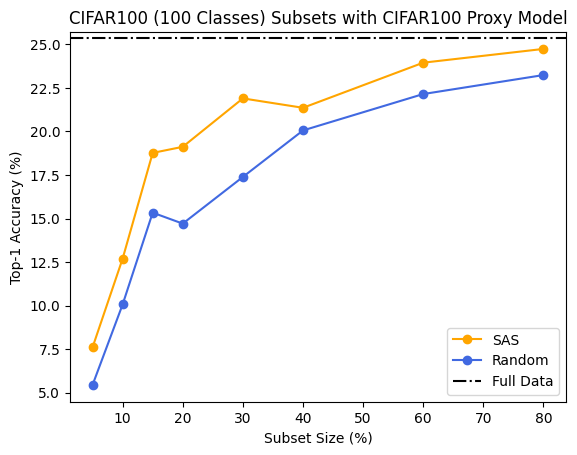

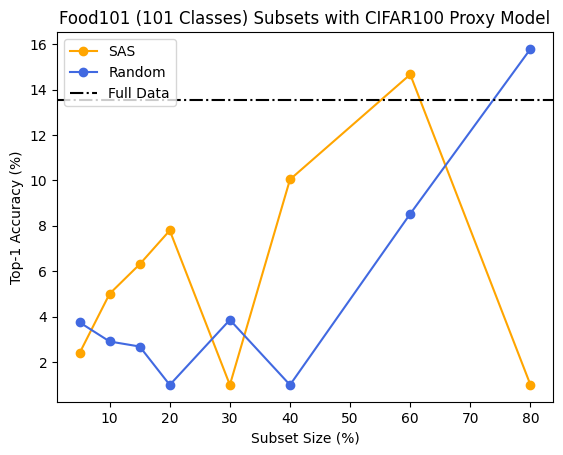

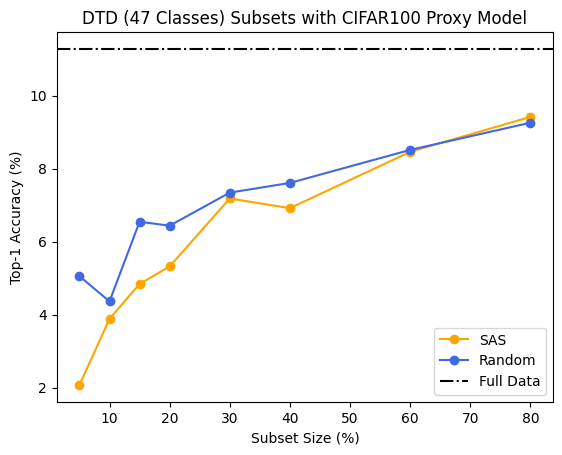

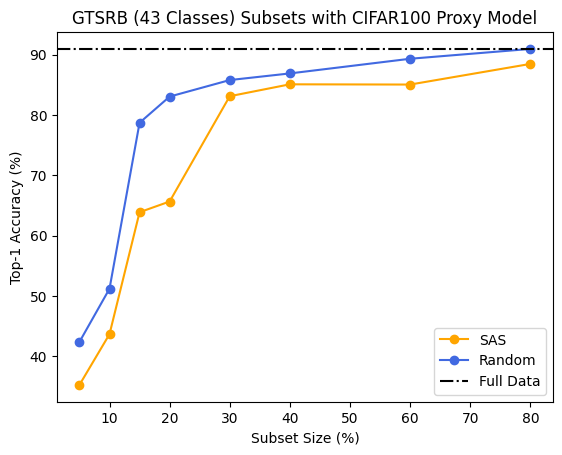

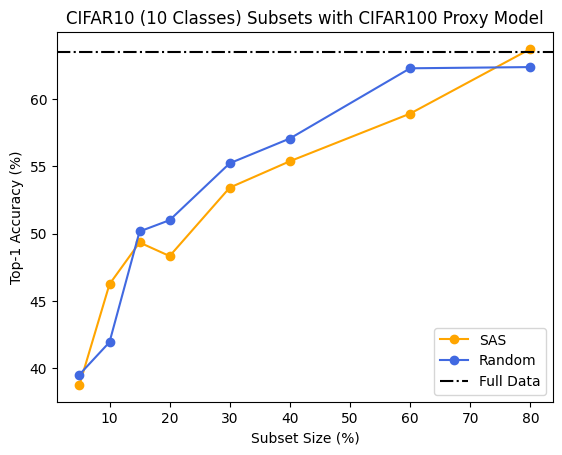

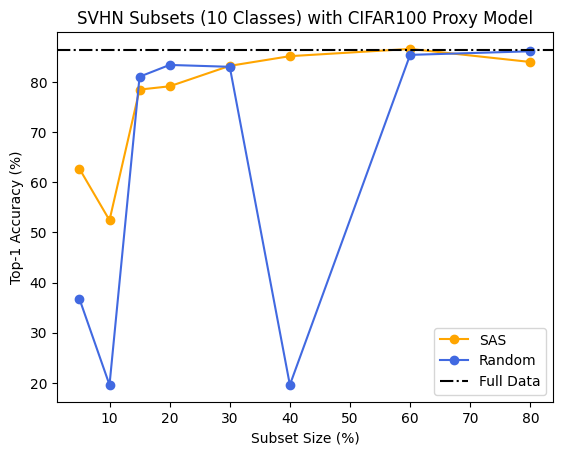

In [64]:
import matplotlib.pyplot as plt

plt.plot([5, 10, 15, 20, 30, 40, 60, 80], [7.61, 12.70, 18.77, 19.12, 21.90, 21.36, 23.95, 24.74], 'o-', color='orange', label='SAS')
plt.plot([5, 10, 15, 20, 30, 40, 60, 80], [5.45, 10.07, 15.34, 14.71, 17.39, 20.06, 22.15, 23.24], 'o-', color='royalblue', label='Random')
plt.axhline(y = 25.37, color = 'black', linestyle = 'dashdot', label='Full Data')
plt.legend(loc="lower right")
plt.xlabel('Subset Size (%)')
plt.ylabel('Top-1 Accuracy (%)')
plt.title('CIFAR100 (100 Classes) Subsets with CIFAR100 Proxy Model')
plt.show()

plt.plot([5, 10, 15, 20, 30, 40, 60, 80], [2.3921, 5.0059, 6.3050, 7.7941, 0.9901, 10.0396, 14.6653, 0.9901], 'o-', color='orange', label='SAS')
plt.plot([5, 10, 15, 20, 30, 40, 60, 80], [3.7465, 2.9030, 2.6812, 0.9901, 3.8574, 0.9901, 8.5267, 15.7901], 'o-', color='royalblue', label='Random')
plt.axhline(y = 13.5327, color = 'black', linestyle = 'dashdot', label='Full Data')
plt.legend(loc="upper left")
plt.xlabel('Subset Size (%)')
plt.ylabel('Top-1 Accuracy (%)')
plt.title('Food101 (101 Classes) Subsets with CIFAR100 Proxy Model')
plt.show()

plt.plot([5, 10, 15, 20, 30, 40, 60, 80], [2.0745, 3.8830, 4.8404, 5.3191, 7.1809, 6.9149, 8.4574, 9.4149], 'o-', color='orange', label='SAS')
plt.plot([5, 10, 15, 20, 30, 40, 60, 80], [5.0532, 4.3617, 6.5426, 6.4362, 7.3404, 7.6064, 8.5106, 9.2553], 'o-', color='royalblue', label='Random')
plt.axhline(y = 11.2766, color = 'black', linestyle = 'dashdot', label='Full Data')
plt.legend(loc="lower right")
plt.xlabel('Subset Size (%)')
plt.ylabel('Top-1 Accuracy (%)')
plt.title('DTD (47 Classes) Subsets with CIFAR100 Proxy Model')
plt.show()

plt.plot([5, 10, 15, 20, 30, 40, 60, 80], [35.2415, 43.6580, 63.8717, 65.6453, 83.1037, 85.0752, 85.0356, 88.4561], 'o-', color='orange', label='SAS')
plt.plot([5, 10, 15, 20, 30, 40, 60, 80], [42.3674, 51.1876, 78.7015, 83.0404, 85.7799, 86.8804, 89.3112, 90.9422], 'o-', color='royalblue', label='Random')
plt.axhline(y = 91.0055, color = 'black', linestyle = 'dashdot', label='Full Data')
plt.legend(loc="lower right")
plt.xlabel('Subset Size (%)')
plt.ylabel('Top-1 Accuracy (%)')
plt.title('GTSRB (43 Classes) Subsets with CIFAR100 Proxy Model')
plt.show()

plt.plot([5, 10, 15, 20, 30, 40, 60, 80], [38.75, 46.24, 49.34, 48.33, 53.42, 55.38, 58.92, 63.73], 'o-', color='orange', label='SAS')
plt.plot([5, 10, 15, 20, 30, 40, 60, 80], [39.52, 41.93, 50.16, 51.00, 55.23, 57.07, 62.29, 62.38], 'o-', color='royalblue', label='Random')
plt.axhline(y = 63.48, color = 'black', linestyle = 'dashdot', label='Full Data')
plt.legend(loc="lower right")
plt.xlabel('Subset Size (%)')
plt.ylabel('Top-1 Accuracy (%)')
plt.title('CIFAR10 (10 Classes) Subsets with CIFAR100 Proxy Model')
plt.show()

plt.plot([5, 10, 15, 20, 30, 40, 60, 80], [62.6805, 52.4239, 78.4729, 79.1295, 83.2091, 85.1375, 86.5819, 83.9774], 'o-', color='orange', label='SAS')
plt.plot([5, 10, 15, 20, 30, 40, 60, 80], [36.7432, 19.5874, 81.0426, 83.3897, 83.0171, 19.5874, 85.3949, 86.1094], 'o-', color='royalblue', label='Random')
plt.axhline(y = 86.3245, color = 'black', linestyle = 'dashdot', label='Full Data')
plt.legend(loc="lower right")
plt.xlabel('Subset Size (%)')
plt.ylabel('Top-1 Accuracy (%)')
plt.title('SVHN Subsets (10 Classes) with CIFAR100 Proxy Model')
plt.show()